# MScFE 610 Econometrics - Submission 2

Group members:

Nansujin Jiang jnsj1002@126.com, Wenbin Zhou zhou.wenbin.x@gmail.com, Lee Chew Peng clee026@e.ntu.edu.sg, Azamat Apraimov aapraimov@nu.edu.kz, Rustam Otarov rotarov@nu.edu.kz 

# Volatility Analysis

The following is a volatility analysis and forecast of Apple (ticker: AAPL) daily stock return. Here, different ARMA-GARCH models were used and their performance was evaluated. 
Before attempting to apply the volatility models, an initial analysis of the natural of the daily returns was conducted. This is done by visualization the log return of the stock using a histogram  and plotting the time plot for both the log return and the squared of log return.   

Data : Apple’s stock return       
Frequency: Daily      
Source: Yahoo Finance      
Dates: from 2015-01-01 to present

In [72]:
library('quantmod')
library('vars')
library("zoo")
library("xts")
library("tidyverse")
library("timeSeries")
library("forecast")
library("ggplot2")
library('rugarch')
library('readr')
library('moments')

[1] "AAPL"

,AAPL.Open,AAPL.High,AAPL.Low,AAPL.Close,AAPL.Volume,AAPL.Adjusted
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2015-01-02,111.39,111.44,107.35,109.33,53204600,100.21645
2015-01-05,108.29,108.65,105.41,106.25,64285500,97.39318
2015-01-06,106.54,107.43,104.63,106.26,65797100,97.40237
2015-01-07,107.20,108.20,106.70,107.75,40105900,98.76815
2015-01-08,109.23,112.15,108.70,111.89,59364500,102.56307
2015-01-09,112.67,113.25,110.21,112.01,53699500,102.67305


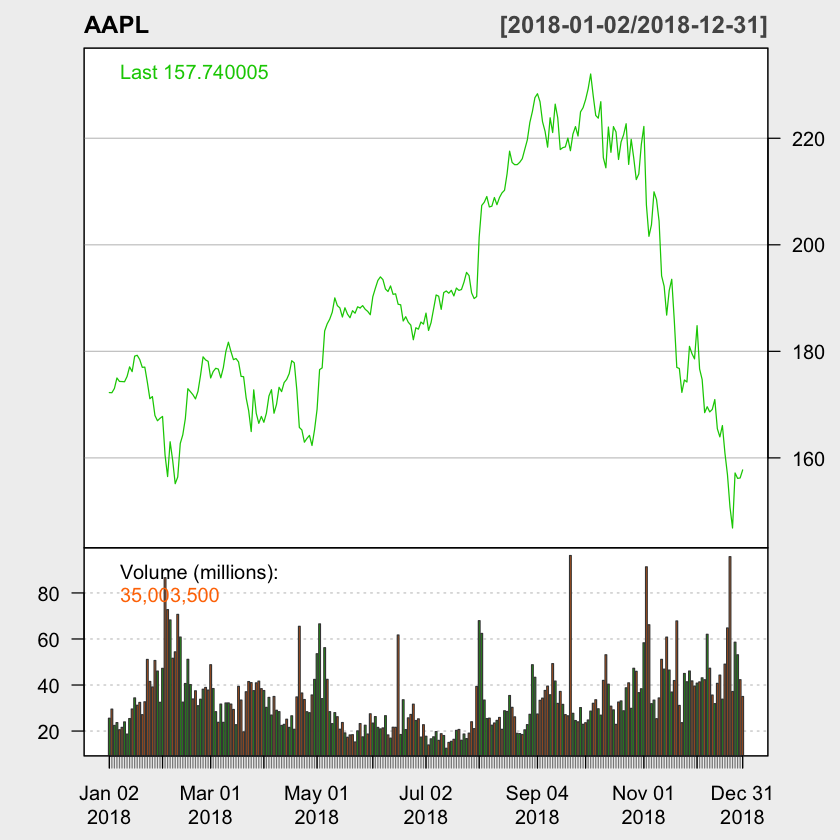

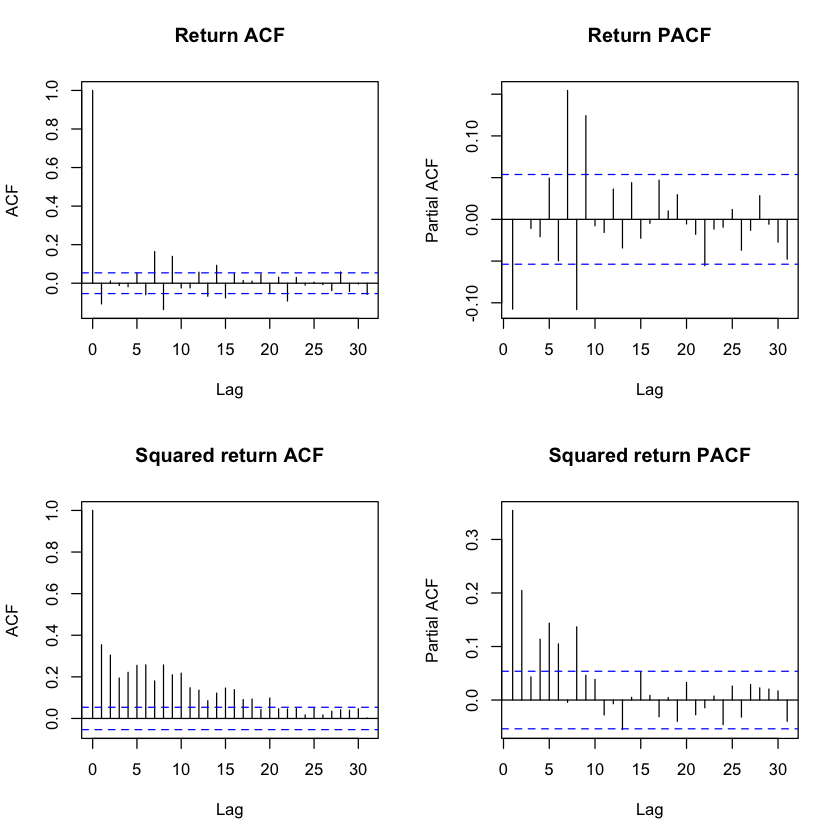

In [51]:
#Download Apple data from yahoofinace
getSymbols("AAPL", from = "2015-01-01", to = Sys.Date())
chartSeries(AAPL, type="line", subset='2018', theme=chartTheme('white'))
df <- data.frame(AAPL)
head(df)

#Calculation of the daily return
ret <- dailyReturn(Cl(AAPL), type = 'log')

#Analysing ACF and PACF
par(mfrow = c(2,2))
acf(ret, main = "Return ACF");
pacf(ret, main = "Return PACF");
acf(ret**2, main = "Squared return ACF");
pacf(ret**2, main = "Squared return PACF")

The log returns are serially uncorrelated, while the squared log returns show significant autocorrelations.    

Compare the histogram and the empirical distribution of daily log return with the normal distribution of the same mean and the standard deviation.

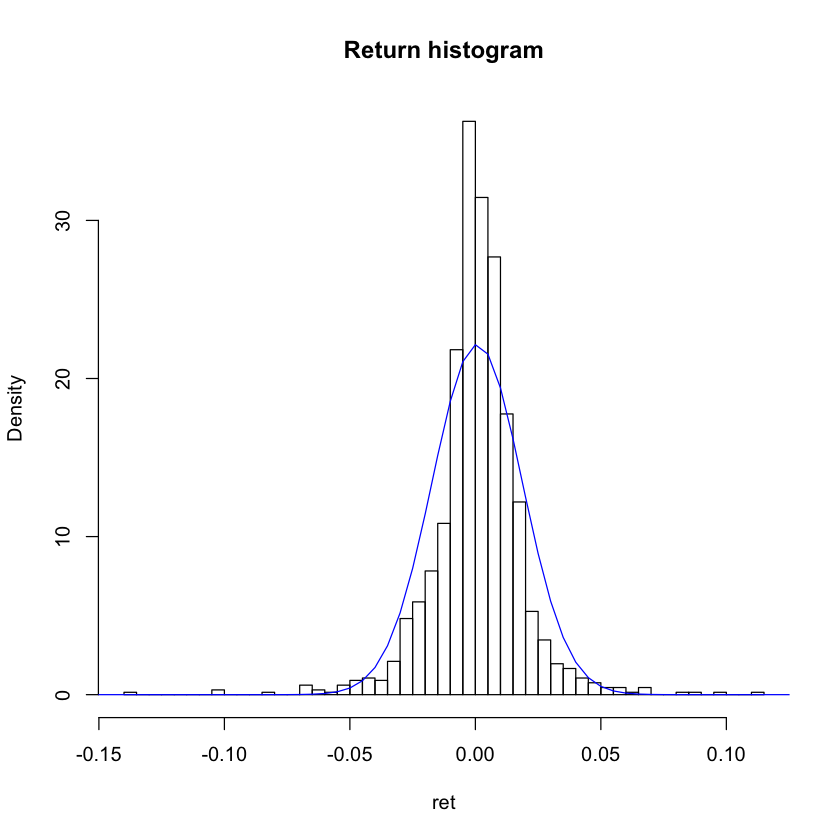

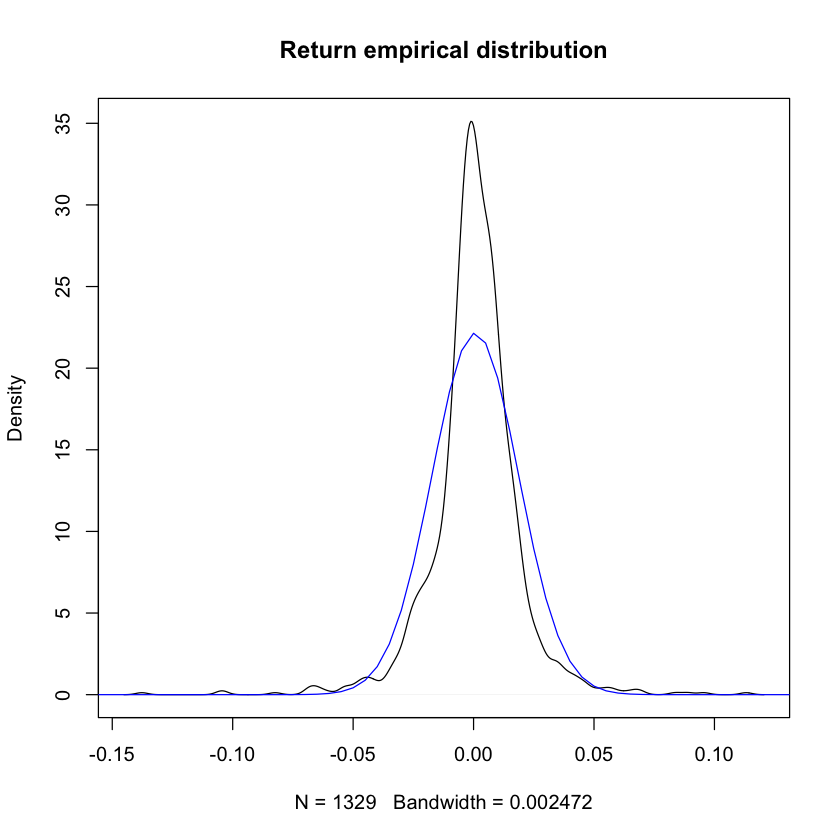

In [35]:
m = mean(ret); s = sd(ret);

hist(ret, nclass=40, freq=FALSE, main = 'Return histogram'); 
curve(dnorm(x, mean = m, sd =s), from =-0.3, to = 0.2, add = TRUE,col = "blue")

plot(density(ret), main = 'Return empirical distribution');
curve(dnorm(x, mean = m, sd = s), from = -0.3, to = 0.2, add = TRUE,col = "blue")

In [36]:
#check for kurtosis
kurtosis(ret)

daily.returns 
     11.00824

From the plot, we can see the excess kurtosis and fat tails. Numerically, it is greater than 3, which indicates excess kurtosis.

## GARCH(1,1)
We'll first use the standard GARCH(p, q) model.    
GARCH(p, q) process may be written as follows:
\begin{equation}
\begin{aligned}
\epsilon_{t} &=\sigma_{t} \eta_{t} \\
\sigma_{t}^{2} &=\omega+\sum_{i=1}^{q} \alpha_{i} \epsilon_{t-i}^{2}+\sum_{j=1}^{q} \beta_{j} \sigma_{t-j}^{2}
\end{aligned}
\end{equation}

Where, $\epsilon_{t}$ is usually the disturbance term of a conditional mean equation and $\eta_{t}$ is independently identical distributions with mean zero and variance 1.    

mu        omega       alpha1        beta1 
0.0016433502 0.0000181958 0.1448827068 0.7966225379


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001643    0.000384   4.2825  1.8e-05
omega   0.000018    0.000004   5.0882  0.0e+00
alpha1  0.144883    0.024156   5.9979  0.0e+00
beta1   0.796623    0.028111  28.3388  0.0e+00

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001643    0.000416   3.9507 0.000078
omega   0.000018    0.000005   3.5858 0.000336
alpha1  0.144883    0.032074   4.5171 0.000006
beta1   0.796623    0.034151  23.3268 0.000000

LogLikelihood : 3649.242 

Information Criteria
------------------------------------
                    
Akaike       -5.4857
Bayes        -5.4701
Shibata      -5.4857
Hannan-Quinn -5.4798

Weig

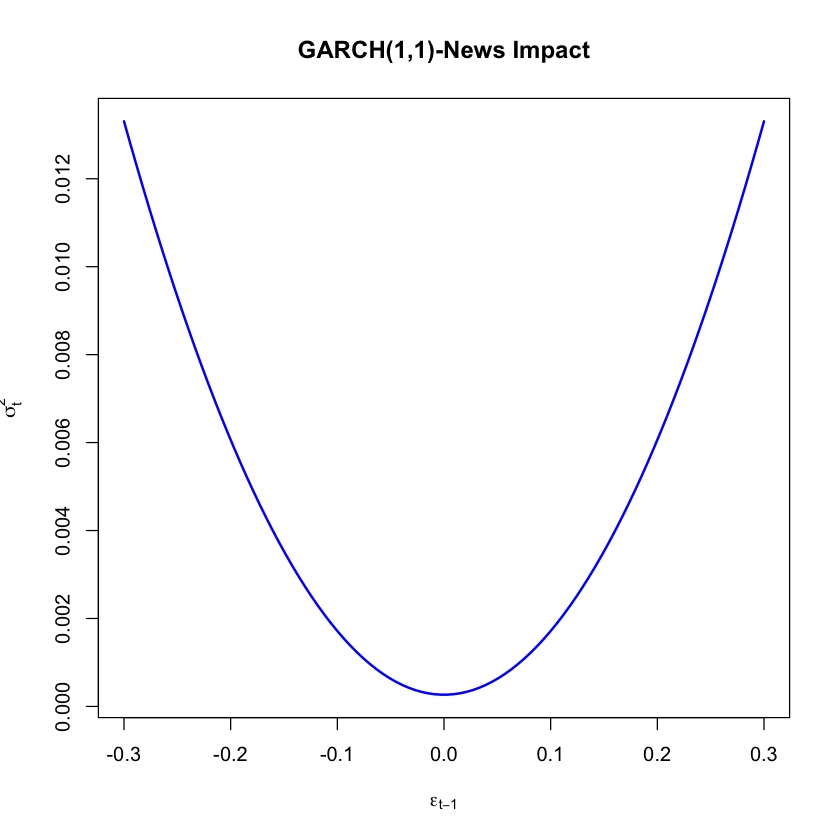

In [55]:
# GARCH(1,1) model
garch11.spec = ugarchspec(variance.model = list(model = "sGARCH", 
                                                garchOrder = c(1,1)), 
                          mean.model = list(armaOrder = c(0,0)))

# fit this model to our data
aapl.garch11.fit = ugarchfit(spec = garch11.spec, 
                             data = ret) 

#parameter estimations
coef(aapl.garch11.fit)

#diagnostic tests
show(aapl.garch11.fit)

#leverage effect, or asymmetric effects in volatility
ni.garch11 <- newsimpact(aapl.garch11.fit)
plot(ni.garch11$zx, ni.garch11$zy, 
     type = "l", 
     lwd = 2, 
     col = "blue",
     main = "GARCH(1,1)-News Impact", 
     ylab= ni.garch11$yexpr, 
     xlab = ni.garch11$xexpr)

The above plot shows no asymmeties present in response to positive and negative shocks. 

The standard GARCH models are able to capture fat tails and volatility clustering but fail to capture asymmetries in distributions and leverage effects.    

So, we need models which will incorporate the asymmetric effects as well. One of the models that will capture this effect is the Exponential GARCH model(EGARCH).

## EGARCH(1,1)

mu        omega       alpha1        beta1       gamma1 
 0.001202948 -0.444850160 -0.157450251  0.946074775  0.152990242


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001203    0.000310   3.8799 0.000105
omega  -0.444850    0.007496 -59.3433 0.000000
alpha1 -0.157450    0.016860  -9.3389 0.000000
beta1   0.946075    0.001286 735.8163 0.000000
gamma1  0.152990    0.004845  31.5757 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001203    0.000390   3.0870 0.002022
omega  -0.444850    0.021093 -21.0902 0.000000
alpha1 -0.157450    0.024566  -6.4092 0.000000
beta1   0.946075    0.002306 410.1808 0.000000
gamma1  0.152990    0.008783  17.4186 0.000000

LogLikelihood : 3678.596 

Information Criteria
------------------------------------
                

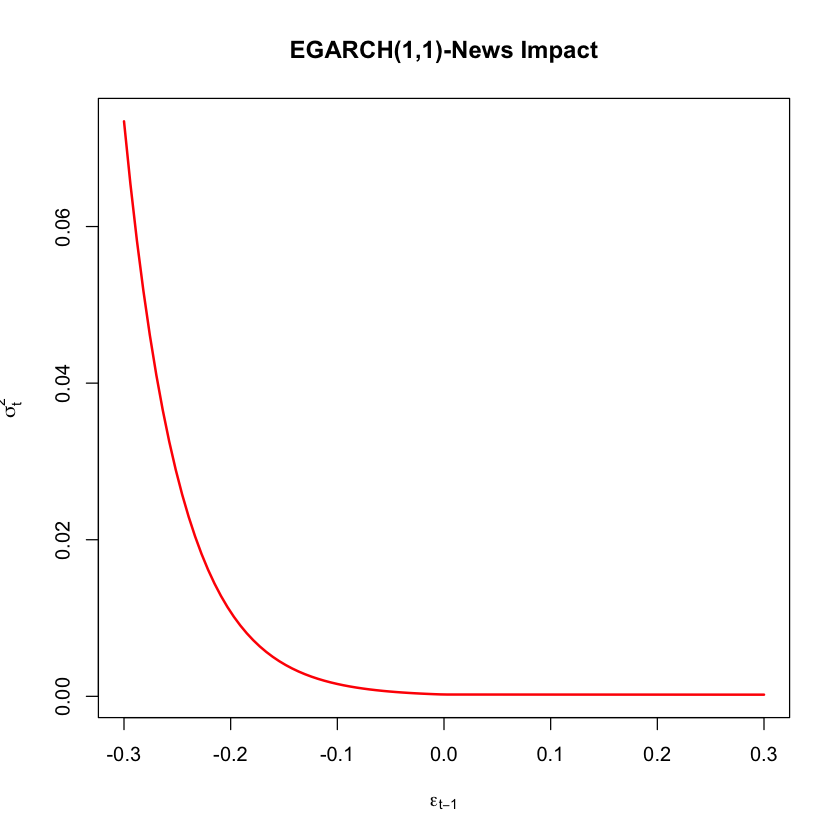

In [48]:
#EGARCH model for capturing the leverage effect
egarch11.spec = ugarchspec(variance.model = list(model = "eGARCH",
                                                 garchOrder = c(1,1)), 
                           mean.model = list(armaOrder = c(0,0))) 

#fit the EGARCH model to our data.
aapl.egarch11.fit = ugarchfit(spec = egarch11.spec, data = ret)

#parameter estimations
coef(aapl.egarch11.fit)

#diagnostic tests
show(aapl.egarch11.fit)

#leverage effect, or asymmetric effects in volatility
ni.egarch11 <- newsimpact(aapl.egarch11.fit)

plot(ni.egarch11$zx, ni.egarch11$zy, 
     type = "l", 
     lwd = 2, 
     col = "red", 
     main = "EGARCH(1,1)-News Impact", 
     ylab= ni.egarch11$yexpr, 
     xlab = ni.egarch11$xexpr)

In the above plot, impact curve reflects the strong asymmetry in response of conditional volatility to shocks and confirms the necessity of asymmetric models.

Based on the statistical analysis abobe, both models are encompassing, however, with a smaller AIC, we will prefer to use the EGARCH model for further simulation and forecasting.

## Forecast using EGARCH

EGARCH model is chosen among other alternative model because it takes into account the asymmetrical effect of prior returns on future returns. As stock prices react to market news, any negative sentiment would result in greater changes in price, and its impact on volatiltity will be much greater than that by a positive shock. Due to this nature of equities trading, eGARCH is considered.


*------------------------------------*
*       GARCH Model Forecast         *
*------------------------------------*
Model: eGARCH
Horizon: 10
Roll Steps: 10
Out of Sample: 10

0-roll forecast [T0=2020-03-16]:
       Series   Sigma
T+1  0.001172 0.06662
T+2  0.001172 0.06136
T+3  0.001172 0.05679
T+4  0.001172 0.05279
T+5  0.001172 0.04928
T+6  0.001172 0.04619
T+7  0.001172 0.04346
T+8  0.001172 0.04103
T+9  0.001172 0.03887
T+10 0.001172 0.03693



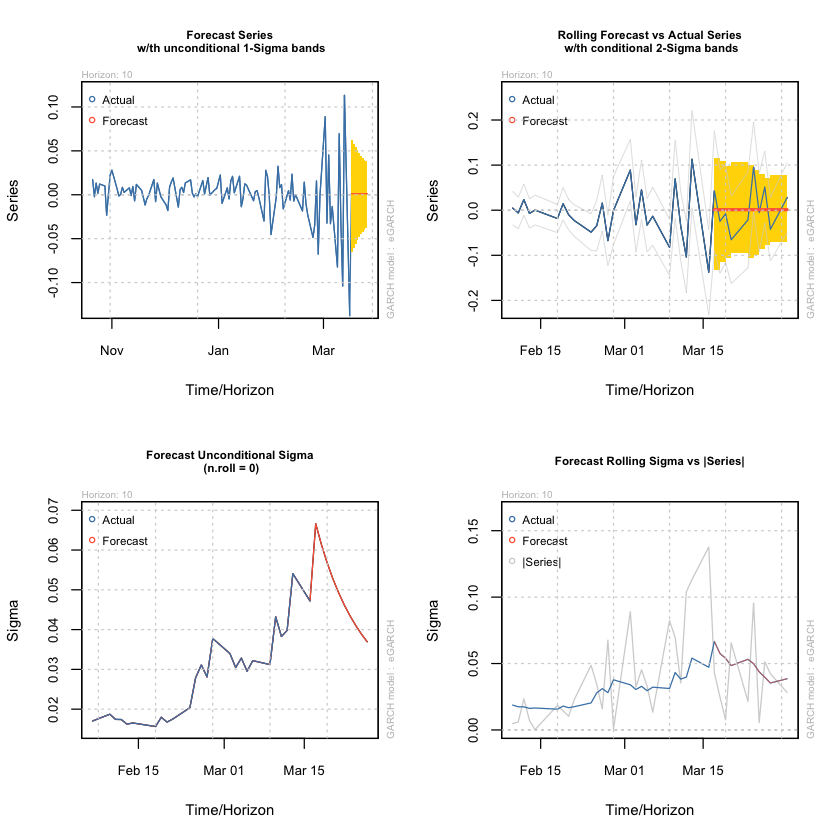

In [49]:
# Simulation and forcasting using the EGARCH model
aapl.egarch11.fit = ugarchfit(spec = egarch11.spec, data = ret, out.sample = 20)
aapl.egarch11.fcst = ugarchforecast(aapl.egarch11.fit, n.ahead = 10, n.roll = 10)

plot(aapl.egarch11.fcst, which = 'all')

#desplay the forcast
aapl.egarch11.fcst

# Multivariate Analysis

## Question 1: Describe the economic theories and models used to calculate equilibrium FX

Williamson describes the concept of an equilibrium exchange rate as a market equilibrium that balances the demand and supply of a currency in an absence of any intervention.    

The exchange rate represents a relationship between the domestic and foreign economy. Testing its volatility and misalignment comprises one of the most important priorities for policy makers.
- Its volatility represents the currency pairs short-run fluctuations oscillating around long-run trends.
- Its misalignment comprises the deviations from the equilibrium called overvaluation and undervaluation.

Significant misalignment may impose major costs and negative pressures, because a highly deviated rate would oscillate greatly in a short or long-run to converge to its equilibrium. Therefore, it's important to estimate the real equilibrium levels. 

### Purchasing power parity (PPP)

Purchasing power parity (PPP) developed by Cassel is the first traditional theory for equilibrium exchange rate determination.   

The PPP states that in a world with functioning efficient markets, all identical goods would be priced equally between two countries, i.e. converted into a common currency they will have a single price, essentially the Law of one price. Numerical empirical studies show that real exchange rate tends toward PPP in an extended long run, making this conver- gence a very slow process and thus, PPP does not hold in short-run.    

This theory states that the equilibrium rate of exchange is determined by the equality of the purchasing power of two inconvertible paper currencies. It implies that the rate of exchange between two inconvertible paper currencies is determined by the internal price levels in two countries. The equilibrium rate of exchange is calculated in the following equation:
\begin{equation}
s_{t}=p_{t}^{*}-p_{t}-c
\end{equation}

where $s_{t}$ is denoted by the log nominal exchange rate, defined as the number of currency units required to purchase one domestic unit, $p_{t}$ is the log domestic price level, $p_{t}^{*}$ is the log foreign price level, c is a constant due to productivity differentials and other factors. We understand price level as follows,
\begin{equation}
p_{t}=\frac{P_{1}}{P_{0}}
\end{equation}
where $P_{1}$ and $P_{0}$ are the price indices in domestic country in the current and base periods respectively. Similiarly for $p_{t}^{*}$.    

From the above variables we see that the PPP model only cares about price levels between two coutries, which in practice might not be enough to do the prediction.

### Uncovered Interest Rate Parity (UIP)
Secondly, we explain the economic theory to calculate equilibrium through Uncovered Interest Rate Parity. It states that the difference in interest rates between two countries will equal the relative change in currency foreign exchange rates over the same period.     

It is one form of interest rate parity used alongside covered interest rate parity. If the uncovered interest rate parity relationship does not hold, then there is an opportunity to make a risk-free profit using currency arbitrage or Forex arbitrage. UIP can be expressed algebraically as follows:
\begin{equation}
E_{t}\left(s_{t+1}\right)-s_{t}=i_{t}^{*}-i_{t}+u
\end{equation}
where we denote by $i_{t}^{*}$ is the equivalent foreign interest rate and $i_{t}$ is the domestic interest rate, u is the risk premium, and $E_{t}\left(s_{t+1}\right)$ an expectation at time t.    

From the above variables, we see that the UIP models only cares about interests rates in two countries, and again we think the method would not be enough for accurate prediction.

### Combining PPP and UIP
As stated above, we see that both PPP amd UIP model have some limitaitons, which only consider limited variables for the predictions, as both were rejected  by some empirical surveys. Proposed in the paper by Dominick Stephens 04 in his paper "the equilibrium exchange rate according to PPP and UIP", the combined PPP and UIP approach has shown advantages under reasonable assumptions. In the combined approach, the interest rates, price level and excahnged rate have been consider together to give better prediciton of the equilibrium FX. 

### Fundamental Equilibrium Exchange Rate (FEER)
The fundamental Equilibrium Exchange Rate (FEER) developed by Williamson to determine the equilibrium rate through a medium-term analysis.     

The FEER emphasizes the factors that are important in the medium instead of only long-run or short-run period. It further assumes that the exchange rate converges to its equilibrium level when the internal and external balances are in equilibrium simultaneously. Therefore, the external balance condition is interpreted as a current account corresponding to capital flows that are consistent with the convergence to the long-run equilibrium, i.e. the underlying capital flows.     

The process of estimating the FEER thus involves identification of these flows. According to Williamson, these flows cannot be identified with the actual flows over some time, because many of the actual flows are transitory or reversible. Neither are these flows likely to be found by investigating the balance of payments accounts as speculative flows can be placed in long-term assets as well. A better approach would be to look at the national accounts, at the savings-investment relationship, i.e. net investment in rest of the world equal net savings of the private sector minus the public sector deficit.

### Natural Equilibrium Exchange Rate (NATREX)
Another method for estimating FX equilibrium is the Natural Equilibrium Exchange Rate (NATREX). It was developed by Stein as a variation of FEER, comprising both medium and long-tern analysis.     

NATREX follows the internal-external balance prepositions which are very similar to FEER.     

In medium term, the equilibrium point is sustainable and ensure internal equilibrium with a capacity of output in the economy and external equilibrium with a balance of payments without cyclical factors, capital or international reserves movements.     

In a long run, the net foreign debt to GDP ratio is stable i.e. the country finance itself internally, and the interest rates at home and abroad are equal.     

The NATREX differs from FEER with respect to its assumptions about the speculative capital flows and changes in the official reserves. 

### Behavioral Equilibrium Exchange Rate (BEER)
The Behavioral Equilibrium Exchange Rate (BEER) represents one of the latest approaches for determining the equilibrium FX rate. It was developed by Clark and MacDonald (1999) as an alternative to FEER for assessing the current value of the exchange rate.     

BEER is primarily an econometric analysis. It estimates the misalignment that occur due to deviations of the actual exchange rate from its estimated values. The BEER is derived from the long-run cointegration relationship of macroeconomic fundamentals which are separated from any cyclical components with the Hodrick-Prescott filter. Unlike the NATREX model that relies on a structural equilibrium concept, the BEER is based upon a statistical notion of equilibrium. It attempts to explain the actual behavior of the real exchange rate based on a set of relevant explanatory regressors. These fundamentals are selected according to what the economic theory prescribes as variables that have an impact on the real exchange rate in medium to short-run period.     

The principle difference between BEER and NATREX is that the latter has a specific theoretical dynamic stock-flow model as a point of departure, whereas the equilibrium real exchange rate depends upon relative thrift and relative differentials.   

BEER is said to be behavioral because it is based on ad-hoc selected variables in accordance to their ability to explain these past movements.   

All in all, the BEER model estimates the fair value of currencies according to short, medium and long-run determinants, and it is an econometric technique that links a large pool of fundamentals and the real exchange rate in a single equation, aiming to explain the past movements of the exchange rate. 

The reduced-form equation proposed by Clark and MacDonald can be written as followed:
\begin{equation}
e_{t}=\beta_{1}^{\prime} Z_{1, t}+\beta_{2}^{\prime} Z_{2, t}+\tau^{\prime} T_{t}+\epsilon_{t}
\end{equation}
where:    
- $Z_{1}$ and $Z_{2}$ are vectors of economic fundamentals that are expected to have effect on the exchange rate over the medium and long term respectively
- $β_{1}$ and $β_{2}$ are vectors of reduced-form coefficients
- T is a vector of transitory factors affecting the real exchange rate in the short run
- τ is a vector of reduced form coefficients
- ε is the noise    

We are going to use this approach to calculate the equilibrium FX, as we are interested in modelling the medium-to-long run valuation of currencies, we can skip the transitory matrix T.     

In our reduced-form equation, the dependent variable is the USD nominal exchange rate relative to SGD.

## Question 2: Indicate macroeconomic variables used to determine the equilibrium FX

In the literature, a large set of fundamentals have been used, ranging from oil price to public debt and unemployment rate. A brief summary of a few studies is presented below:

<img src='models review.png' width=600 height=600>

We're using BEER approach to determine the equilibrium FX, an important concept of BEER is that there is no prior theory for the choice of economic variables; hence, the choice of variables is based on economic intuition and data simplicity and availability. 
We will use the following variables to help us to calculate the equilibrium exchange rate: 
- GDP Per Capita Ratio
- Real Interest Rate Differential 
- CPI Ratio
- Net Foreign Asset Holding Ratio
- Current Account Balance Gap

Variable | Factor | Rationale
--- | --- | ---
GDP Per Capita Ratio| Measure of productivity | Increased productivity generally leads to appreciation of its currency, as the value of goods and services are increased. Unlike other indicators of productivity such as total factor productivity, GDP per capita is more straightforward and easier to estimate.
Real Interest Rate Differential | Capital inflow attraction level | IR is one of the drivers of capital flow inflow in economy. Higher interest rates generally attract higher capital inflow, and so drives demand for local currency.
CPI Ratio | Terms of trade | Ratio of exports to imports is an important indicator, as trade drives demand for goods and so for local currency, as well as for capital flow.
Net Foreign Asset Holding Ratio  | Current fiscal position | FA is frequently used for adjusting fiscal position of the country, especially in case of lender or creditor relations. Positive monetary policy interventions also create stability in the economy and tend to increase demand for its currency. And vice versa, in case of deficit, depreciation allows gaining advantage in exports, decreasing borrowing cost during government debt. 
Current Account Balance Gap  | Current fiscal position | Same as above.

## Question 3: Explain the connection between linear regression and Vector Error Correction (VEC)

The connection between linear regression and Vector Error Correction stems from the problem of spurious regressions when working with non-stationary time-series. 

Spurious regression arises when we regress a unit root process on an independent unit root process, and this causes significant results and a well-fitted model even if there is no real-world relationship between the variables of interest. 

The one and only case in which it is valid to regress one unit-root process onto another is if there exists a linear combination of the two processes such that the resulting ​cointegrating relationship ​is integrated to an order of 0, i.e. is stationary. This process is known as ​Cointegration​ and is used to uncover the long run dynamics of a non-stationary time-series. 

Therefore, it is important to look for cointegrating relationships in order to prove there is a long-term relationship between the two non-stationary variables in both levels and differences.

This is achieved by using the cointegration approach developed by Engle and Granger which consists of modelling an error correction model which accounts for both the short-run dynamics (embedded in the differences relationship) and the long-run dynamics (embedded in the levels relationship at equilibrium). 

This approach however has several limitations, namely that it only considers one cointegrating relationship at a time. Therefore, it is useful instead to use the Vector Error Correction Model (VECM) to make sense of the short-run and long-run dynamics of non-stationary variables across several cointegrating relationships, i.e. linear combinations.

The VECM(p) is an alternative representation of the VAR(p) process, as shown in equation below, which is manipulated algebraically. The manipulation give rise to the matrix $\Pi$, which can be leveraged on to test for cointegration using the Johansen test.
\begin{equation}
\Delta x_t=\Pi x_{t-1}+C_{1}\Delta x_{t-1}+\epsilon_{t} 
\end{equation}


With the Johansen test, the matrix Π, the error correction terms for long run cointegrating relationships, are estimated, albeit imperfectly. What remains are the short-run dynamics, represented by C1xt-1 and the error coefficients t. To determine the remaining coefficients in the VECM,  one may use the conditional maximum likelihood estimation method, with the assumption that the innovations t have a multivariate normal distribution. This application is akin to applying the OLS linear regression on to each of the equation separately.

In conclusion, we can see that the connection between linear regression and the VECM process lies in investigating both the short-run and long-run dynamics of non-stationary variables that have cointegrating relationships.


## Question 4: Calculate the equilibrium FX using VEC and comment all your results. You may use the Behavioral Equilibrium Exchange Rate (BEER) approach

This part is to estimate the VEC model and forecast the price of the USD/SGD using VEC model, along with the BEER approach.    

We assume that FX prices and macroeconomic varables are related to each other through a long-run equilibrium. Based on this assumption, we conduct cointegration test and estimate the VEC model. Finally, we forecast future FX price.

### Macroeconomic Variables and Data Used

The choice of macroeconomic variables that are expected to affect the exchange rate in addition to explaining the economic intuition. For our study and the frequency of the data, we chose to use the following macroeconomic variables:    

- (GDP)  GDP Per Capita Ratio
- (IR)  Real Interest Rate Differential
- (CPI)  CPI Ratio   
- (FA)  Net Foreign Asset Holding Ratio
- (CA)  Current Account Balance Gap     

FX: USD/SGD 

Time period: 1960-2017  

Frequency: all observations are annually

Data source: World Bank national accounts data, and OECD National Accounts data files

In [22]:
library(tseries)
library(vars)
library(tsDyn)
library(urca)
library(readxl) 
library(tidyverse)

In [2]:
df <- read_excel("data_agr.xlsx")
df <- na.omit(df)
head(df)

date <- df[,1]
data <- df[,2:7]

# data standardization
new_data <- scale(data)
new_df <- cbind(date, new_data)
head(new_df)

Year,USDSGD,GDP Per Capita Ratio,Interest Rate Differential,CPI Ratio,Net Foreign Asset Holding Ratio,Current Acc Balance Gap
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1960,3.0612,7.0250,-1.2432,-0.4929,11.4955,17.7752
1961,3.0612,6.8275,-1.2861,-0.4962,10.7528,17.7752
1962,3.0612,6.8713,-1.3500,-0.5000,9.4013,17.7752
1963,3.0612,6.6011,-1.1807,-0.4953,8.5396,17.7752
1964,3.0612,7.3608,-1.0264,-0.4931,7.7777,17.7752
1965,3.0612,7.4100,-1.0598,-0.5000,6.3506,17.7752


,Year,USDSGD,GDP Per Capita Ratio,Interest Rate Differential,CPI Ratio,Net Foreign Asset Holding Ratio,Current Acc Balance Gap
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1960,1.589144,1.937979,-0.4101202,1.410899,2.1816545,1.294907
2,1961,1.589144,1.844647,-0.4272545,1.393768,1.9916729,1.294907
3,1962,1.589144,1.865345,-0.4527763,1.374041,1.6459610,1.294907
4,1963,1.589144,1.737657,-0.3851576,1.398440,1.4255393,1.294907
5,1964,1.589144,2.096669,-0.3235299,1.409861,1.2306463,1.294907
6,1965,1.589144,2.119919,-0.3368699,1.374041,0.8655961,1.294907


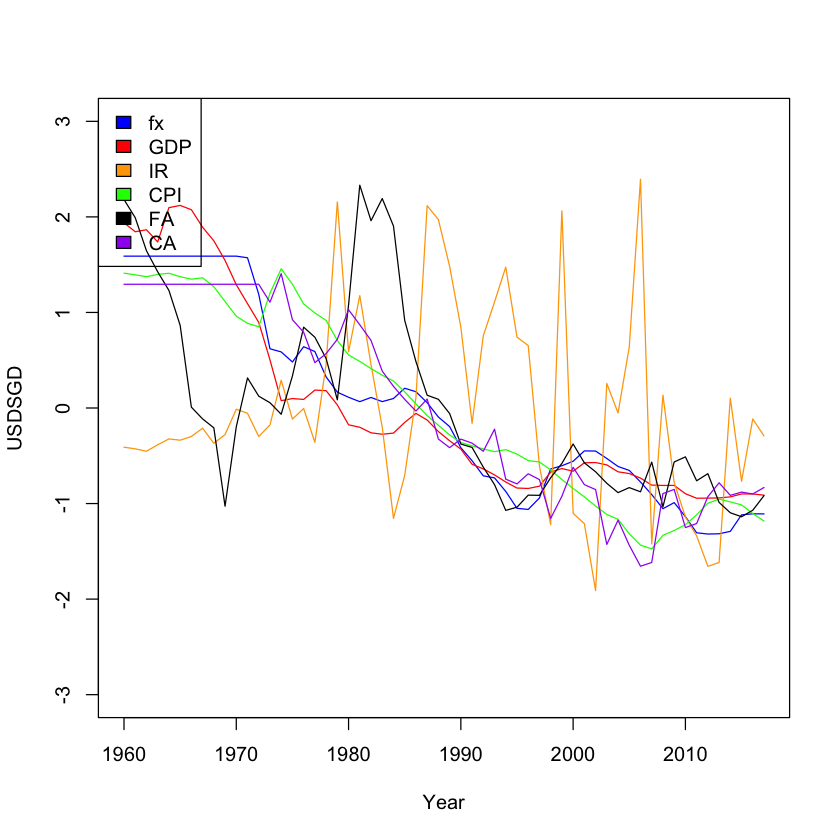

In [3]:
fx <- new_df[ ,1:2]
GDP <- new_df[,c(1,3)]
IR <- new_df[,c(1,4)]
CPI <- new_df[,c(1,5)]
FA <- new_df[,c(1,6)]
CA <- new_df[,c(1,7)]
plot(fx,
     type="l",
     col="blue",
     ylim=c(-3,3))
lines(GDP, col="red")
lines(IR, col="orange")
lines(CPI, col="green")
lines(FA, col="black")
lines(CA, col="purple")
legend("topleft",
       c("fx","GDP",'IR','CPI','FA','CA'),
       fill=c("blue","red","orange","green","black","purple"))

### ADF test
The commonly accepted Augmented Dickey-Fuller (ADF) unit root test are adopted to stationary test of FX, GDP, IR, CPI, FA and CA. The test results are shown below:

In [4]:
apply(new_data,2,adf.test) # Apply adf.test column-wise on df

$USDSGD

	Augmented Dickey-Fuller Test

data:  newX[, i]
Dickey-Fuller = -1.9166, Lag order = 3, p-value = 0.6083
alternative hypothesis: stationary


$`GDP Per Capita Ratio`

	Augmented Dickey-Fuller Test

data:  newX[, i]
Dickey-Fuller = -1.3937, Lag order = 3, p-value = 0.8195
alternative hypothesis: stationary


$`Interest Rate Differential`

	Augmented Dickey-Fuller Test

data:  newX[, i]
Dickey-Fuller = -3.4823, Lag order = 3, p-value = 0.05169
alternative hypothesis: stationary


$`CPI Ratio`

	Augmented Dickey-Fuller Test

data:  newX[, i]
Dickey-Fuller = -2.0756, Lag order = 3, p-value = 0.5441
alternative hypothesis: stationary


$`Net Foreign Asset Holding Ratio`

	Augmented Dickey-Fuller Test

data:  newX[, i]
Dickey-Fuller = -2.8895, Lag order = 3, p-value = 0.2156
alternative hypothesis: stationary


$`Current Acc Balance Gap`

	Augmented Dickey-Fuller Test

data:  newX[, i]
Dickey-Fuller = -0.87533, Lag order = 3, p-value = 0.9498
alternative hypothesis: stationary



<b> Summary </b>

| Macroeconomic Indicators | p-value|
| --- | --- |
| USDSGD | 0.6083 |
| GDP Per Capita Ratio | 0.8195 |
| CPI Ratio | 0.05169 |
| Interest Rate Differential | 0.05169 |
| Net Foreign Asset Holding Ratio |0.5441 | 
| Current Account Balance Gap | 0.9498 |

Using significant levels of 1%, 5% and 10%, the test results above show that level value of the 6 series is nonstationary. 
Further differencing is required to obtain stationary series. A further test indicates that all 6 variables are first-order difference stationary as shown below:

In [5]:
diff1 <- diff(as.matrix(new_data))
apply(diff1,2,adf.test) 

Warning message in FUN(newX[, i], ...):
“p-value smaller than printed p-value”
Warning message in FUN(newX[, i], ...):
“p-value smaller than printed p-value”


$USDSGD

	Augmented Dickey-Fuller Test

data:  newX[, i]
Dickey-Fuller = -3.566, Lag order = 3, p-value = 0.04395
alternative hypothesis: stationary


$`GDP Per Capita Ratio`

	Augmented Dickey-Fuller Test

data:  newX[, i]
Dickey-Fuller = -4.3492, Lag order = 3, p-value = 0.01
alternative hypothesis: stationary


$`Interest Rate Differential`

	Augmented Dickey-Fuller Test

data:  newX[, i]
Dickey-Fuller = -5.7101, Lag order = 3, p-value = 0.01
alternative hypothesis: stationary


$`CPI Ratio`

	Augmented Dickey-Fuller Test

data:  newX[, i]
Dickey-Fuller = -3.6169, Lag order = 3, p-value = 0.03968
alternative hypothesis: stationary


$`Net Foreign Asset Holding Ratio`

	Augmented Dickey-Fuller Test

data:  newX[, i]
Dickey-Fuller = -3.9288, Lag order = 3, p-value = 0.01904
alternative hypothesis: stationary


$`Current Acc Balance Gap`

	Augmented Dickey-Fuller Test

data:  newX[, i]
Dickey-Fuller = -3.8995, Lag order = 3, p-value = 0.02031
alternative hypothesis: stationary



<b> Summary </b>

| diff(Macroeconomic Indicators) | p-value|
| --- | --- |
| diff(USDSGD) | 0.04395 |
| diff(GDP Per Capita Ratio) | 0.01 |
| diff(Interest Rate Differential) | 0.01 |
| diff(CPI Ratio) | 0.03968 |
| diff(Net Foreign Asset Holding Ratio) |0.01904 | 
| diff(Current Account Balance Gap) | 0.02031 |

From the results above, using a significant level of 5%, we determine that by differencing all variables by 1, we get a stationary series. In other words, all variables here can be considered I(1).

Since it is a necessary condition of applying cointegration analysis that the series should be non-stationary at levels or should not be I(0) and have the same order of integration, our case meets the requirement.

In [6]:
diffdata <- diff1 
head(diffdata) 

USDSGD,GDP Per Capita Ratio,Interest Rate Differential,CPI Ratio,Net Foreign Asset Holding Ratio,Current Acc Balance Gap
0,-0.09333266,-0.01713434,-0.01713143,-0.1899816,0
0,0.02069858,-0.02552177,-0.01972710,-0.3457119,0
0,-0.12768853,0.06761872,0.02439931,-0.2204217,0
0,0.35901174,0.06162769,0.01142095,-0.1948930,0
0,0.02325046,-0.01334002,-0.03582026,-0.3650502,0
0,-0.04479968,0.03886179,-0.02595671,-0.8566440,0


### Estimation of VAR Model
We need to first estimate a VAR Model to select the optimal number of lags.

In [7]:
# Estimate a Vector Auto Regression

VAR_model <- VAR(diffdata, lag.max = 24, type = "none",ic="AIC")
summary(VAR_model) 

Warning message in log(sigma.det):
“NaNs produced”
Warning message in log(sigma.det):
“NaNs produced”
Warning message in log(sigma.det):
“NaNs produced”



VAR Estimation Results:
Endogenous variables: USDSGD, GDP.Per.Capita.Ratio, Interest.Rate.Differential, CPI.Ratio, Net.Foreign.Asset.Holding.Ratio, Current.Acc.Balance.Gap 
Deterministic variables: none 
Sample size: 51 
Log Likelihood: 304.608 
Roots of the characteristic polynomial:
0.9433 0.9433 0.9227 0.916 0.916 0.9103 0.9103 0.908 0.908 0.9043 0.9043 0.8967 0.8967 0.8964 0.8964 0.8695 0.8695 0.867 0.867 0.8374 0.8374 0.8318 0.8318 0.8147 0.8147 0.8126 0.8126 0.7839 0.7839 0.7748 0.7748 0.7581 0.7552 0.7552 0.4298 0.4298
Call:
VAR(y = diffdata, type = "none", lag.max = 24, ic = "AIC")


Estimation results for equation USDSGD: 
USDSGD = USDSGD.l1 + GDP.Per.Capita.Ratio.l1 + Interest.Rate.Differential.l1 + CPI.Ratio.l1 + Net.Foreign.Asset.Holding.Ratio.l1 + Current.Acc.Balance.Gap.l1 + USDSGD.l2 + GDP.Per.Capita.Ratio.l2 + Interest.Rate.Differential.l2 + CPI.Ratio.l2 + Net.Foreign.Asset.Holding.Ratio.l2 + Current.Acc.Balance.Gap.l2 + USDSGD.l3 + GDP.Per.Capita.Ratio.l3 + Interest.R

In [8]:
VARselect(data.matrix(diffdata),lag.max = 24)

,1,2,3,4,5,6,7,8,9,10,⋯,15,16,17,18,19,20,21,22,23,24
AIC(n),-2.230876e+01,-2.163316e+01,-2.170082e+01,-2.660889e+01,-1.789224e+02,-Inf,-Inf,-Inf,-Inf,-Inf,⋯,-Inf,-Inf,-Inf,-Inf,-Inf,-Inf,-Inf,-Inf,-Inf,-Inf
HQ(n),-2.166790e+01,-2.044300e+01,-1.996136e+01,-2.432013e+01,-1.760843e+02,-Inf,-Inf,-Inf,-Inf,-Inf,⋯,-Inf,-Inf,-Inf,-Inf,-Inf,-Inf,-Inf,-Inf,-Inf,-Inf
SC(n),-2.040411e+01,-1.809596e+01,-1.653107e+01,-1.980659e+01,-1.704875e+02,-Inf,-Inf,-Inf,-Inf,-Inf,⋯,-Inf,-Inf,-Inf,-Inf,-Inf,-Inf,-Inf,-Inf,-Inf,-Inf
FPE(n),2.130454e-10,5.274441e-10,9.865628e-10,4.547788e-11,2.692825e-74,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Using the Akaike Information Criterion to select the lag length of 6

#### Impulse Response Functions

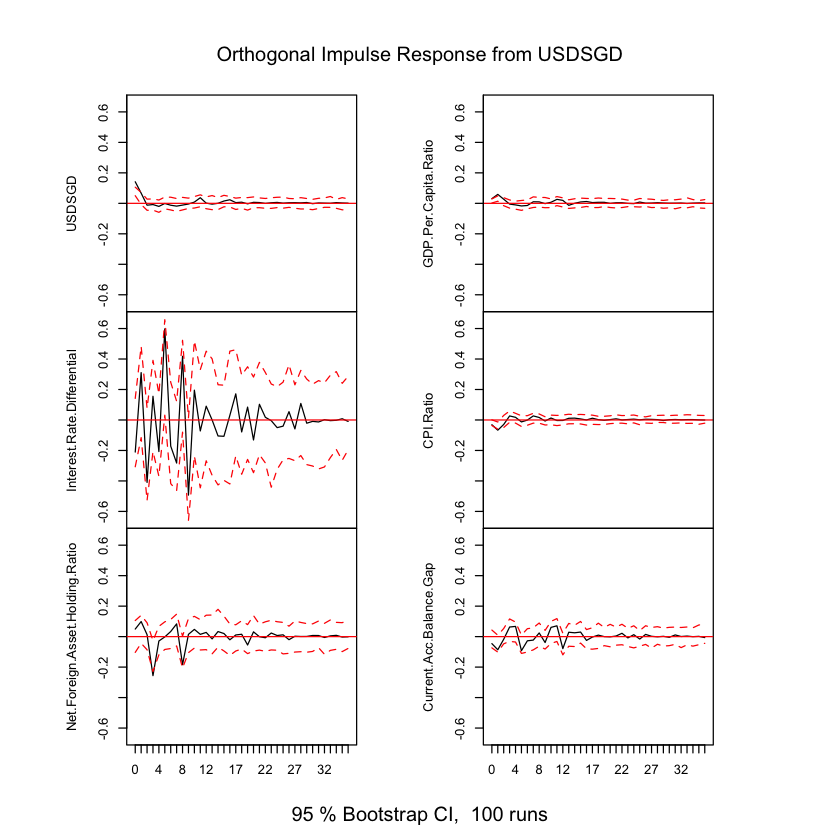

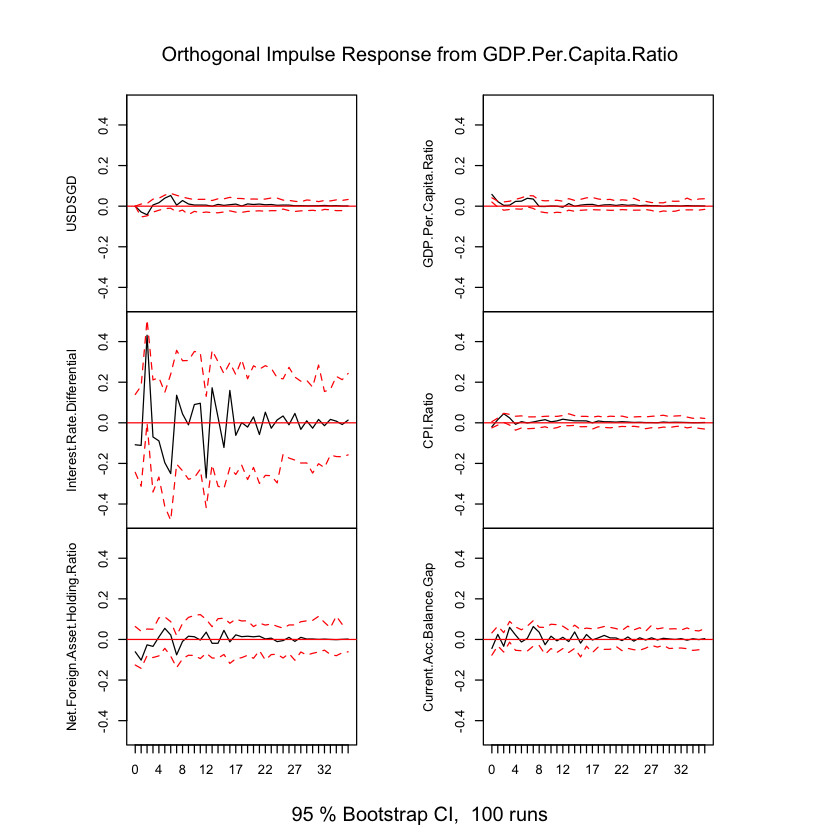

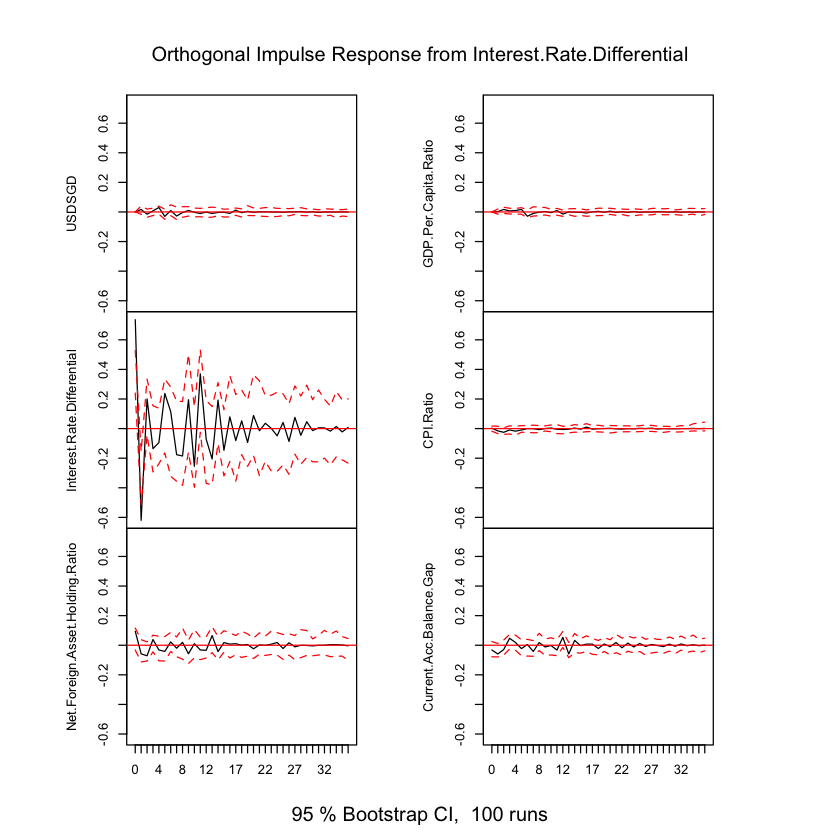

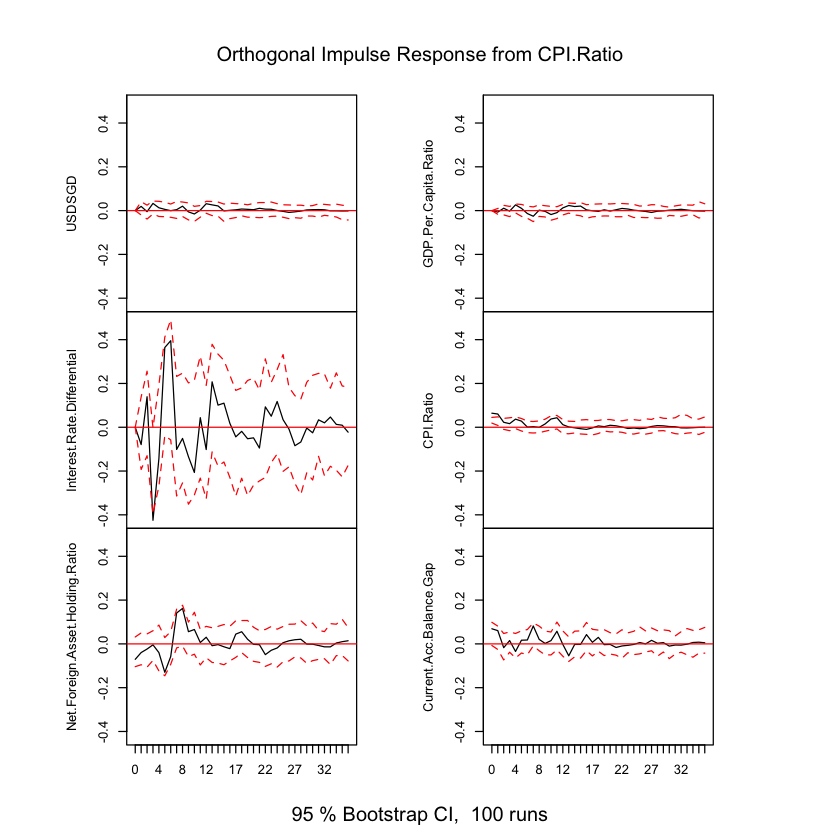

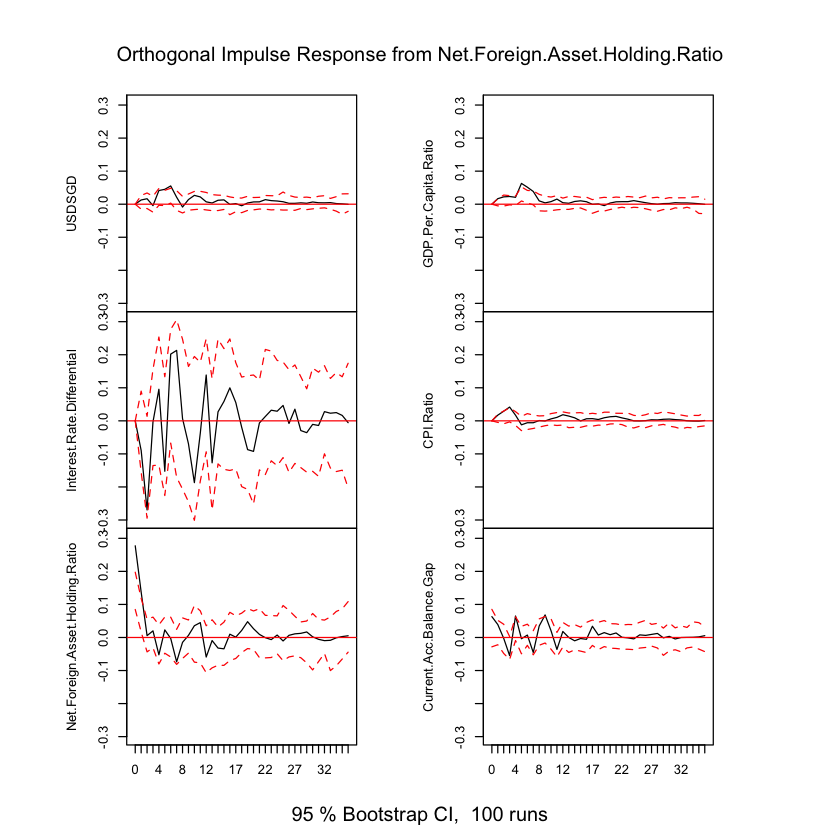

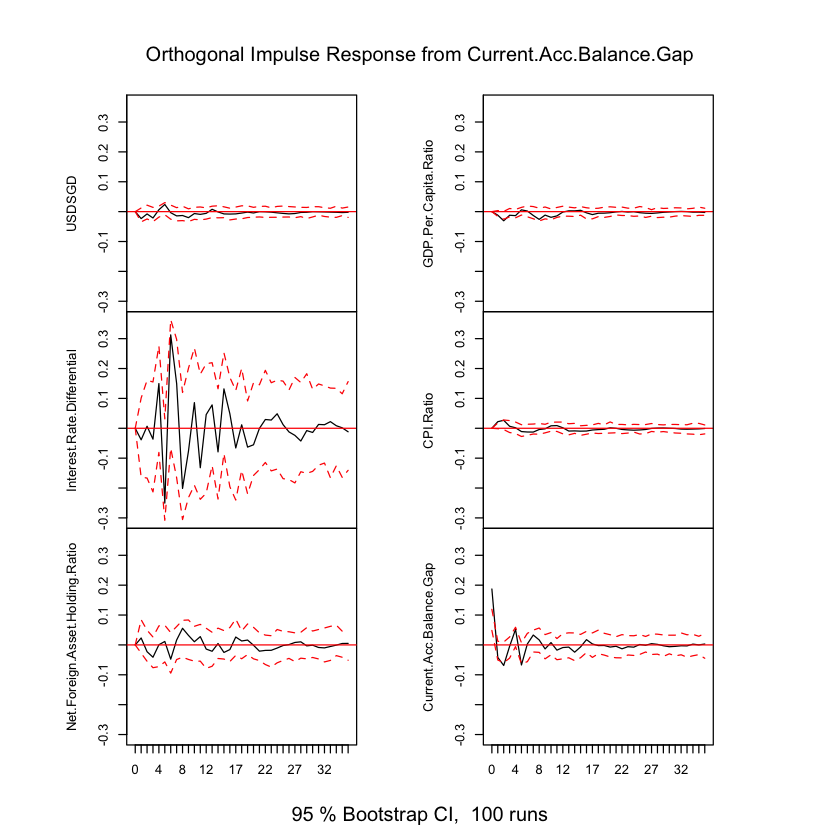

In [9]:
options(warn=-1)
# compute and plot the impulse response functions
# Since we have 6 variables with 6 errors, there are 36 of these impulse response functions.
VAR_irf <- irf(VAR_model, n.ahead = 36,boot = TRUE, ci = 0.95)
plot(VAR_irf)

Impulse response function is adopted to reflect shock effect of a system on an internal variable, all variables here show small impact on USDSGD in long term.

#### Error Variance Decomposition

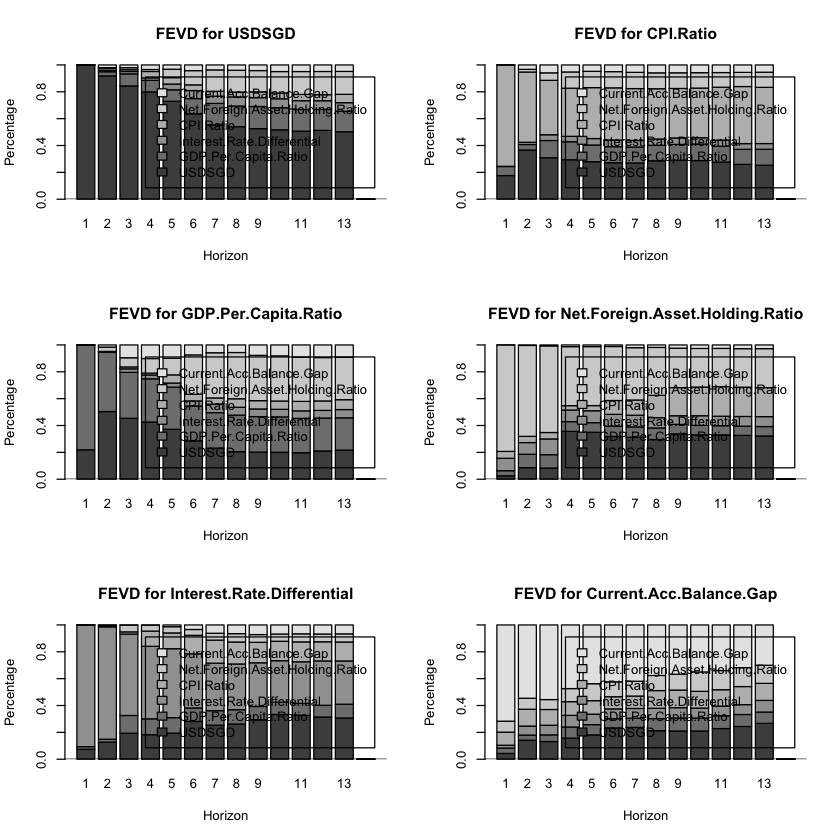

In [10]:
# compute and plot the forecast error variance decomposition
VAR_fevd <- fevd(VAR_model,n.ahead = 13)
plot(VAR_fevd)

Variance decomposition refers to the decomposition of mean square error into contributions of each variable, it can be applied to analyze the influence of each variable’s update on other variables, which shows relative effects.    

According to the first figure "FEVD for USDSGD", in USDSGD predicted variance, contribution of USDSGD change begins to gradually decline from the first period, reaches 58% in the 7th period and returns to a stable level. Other variables' contribution rates totally rise to 42% at the 7th periods and then maintain stability until the 13th period.

#### Residual Analysis

In [11]:
# obtain residuals:
resids  = residuals(VAR_model)
head(resids)

,USDSGD,GDP.Per.Capita.Ratio,Interest.Rate.Differential,CPI.Ratio,Net.Foreign.Asset.Holding.Ratio,Current.Acc.Balance.Gap
1,-0.03697881,-0.056319961,0.01332128,0.030193247,-0.11234732,0.10879841
2,-0.01171311,0.004411769,0.11858662,-0.003876421,0.05480885,-0.06071107
3,-0.04964089,-0.024142592,0.07160519,0.019030656,-0.14927095,-0.10471163
4,0.02555955,-0.062902288,-0.14497037,-0.010939246,0.15235607,-0.02831981
5,0.10547041,0.056236904,-0.47118727,0.027029594,0.10186794,0.15475593
6,-0.15204727,0.015404355,-0.26830331,-0.004743783,-0.12036143,0.04605752


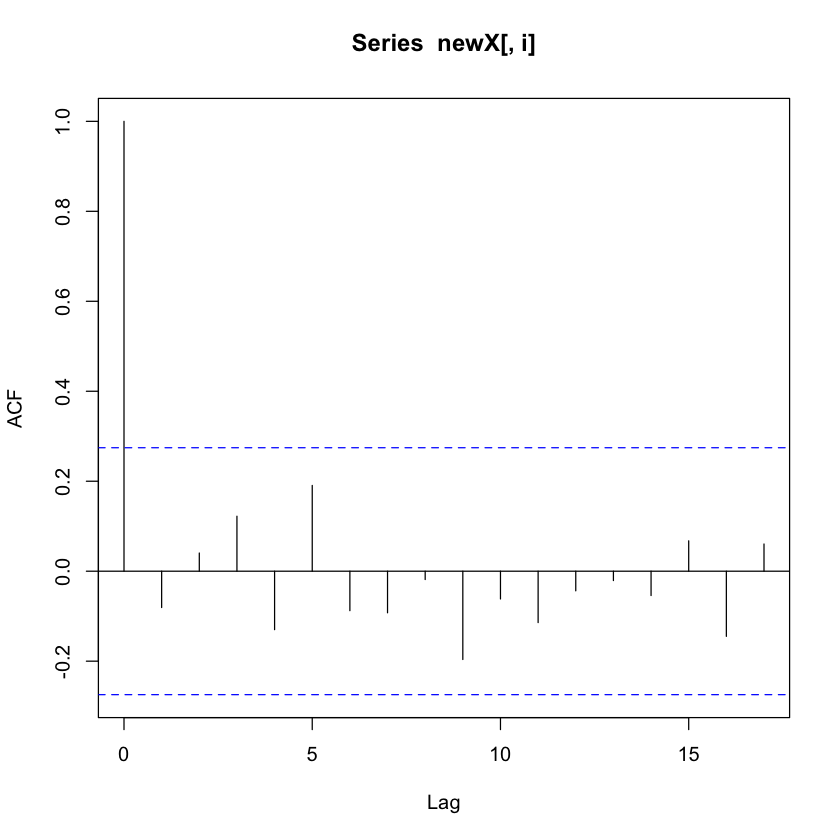

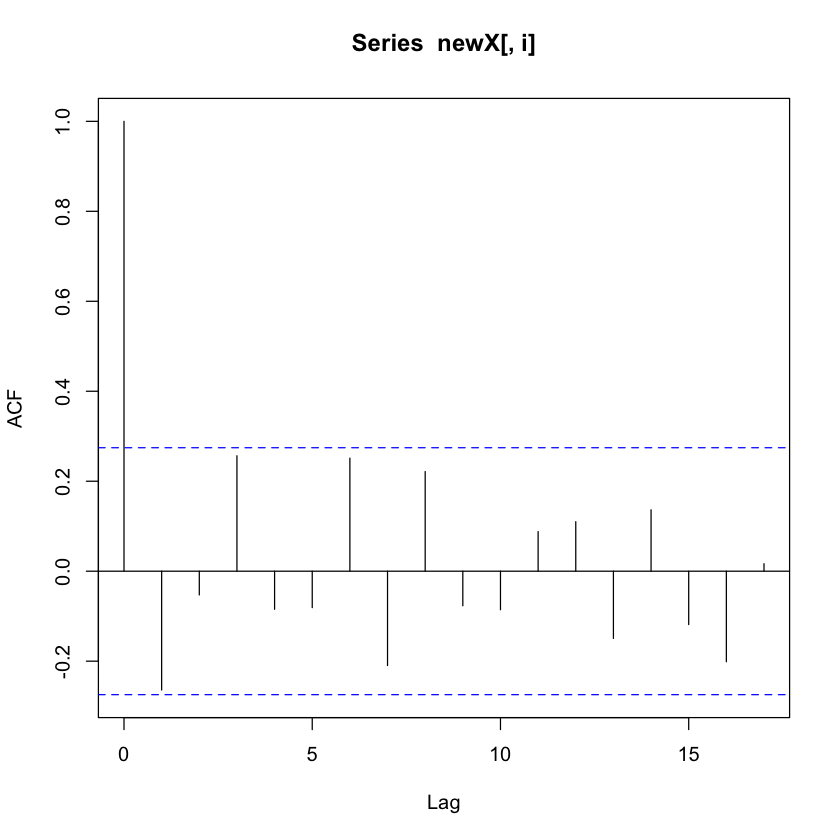

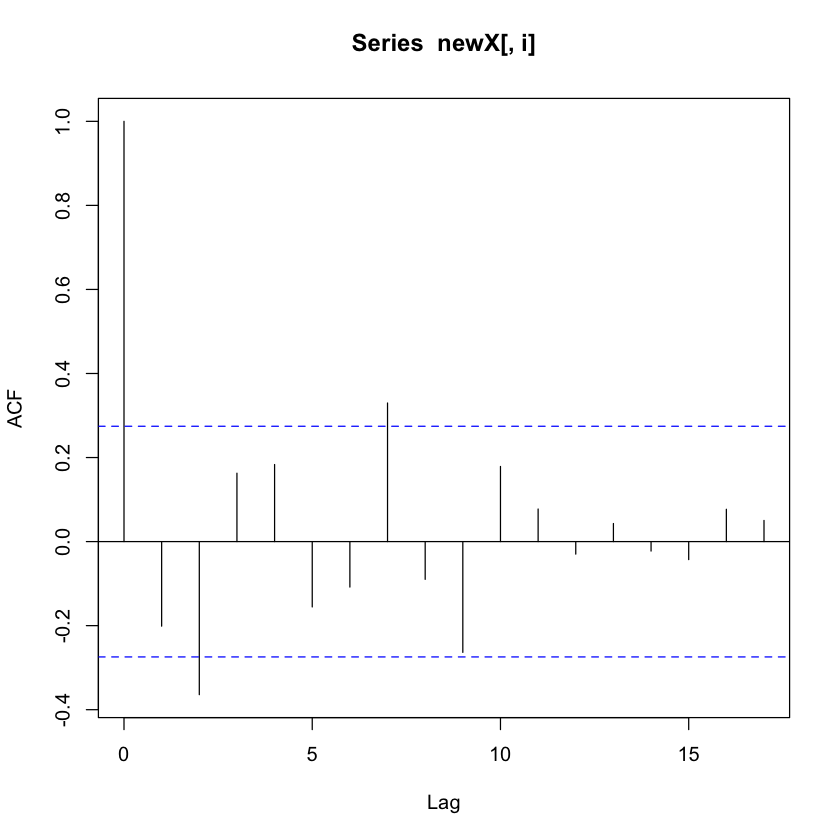

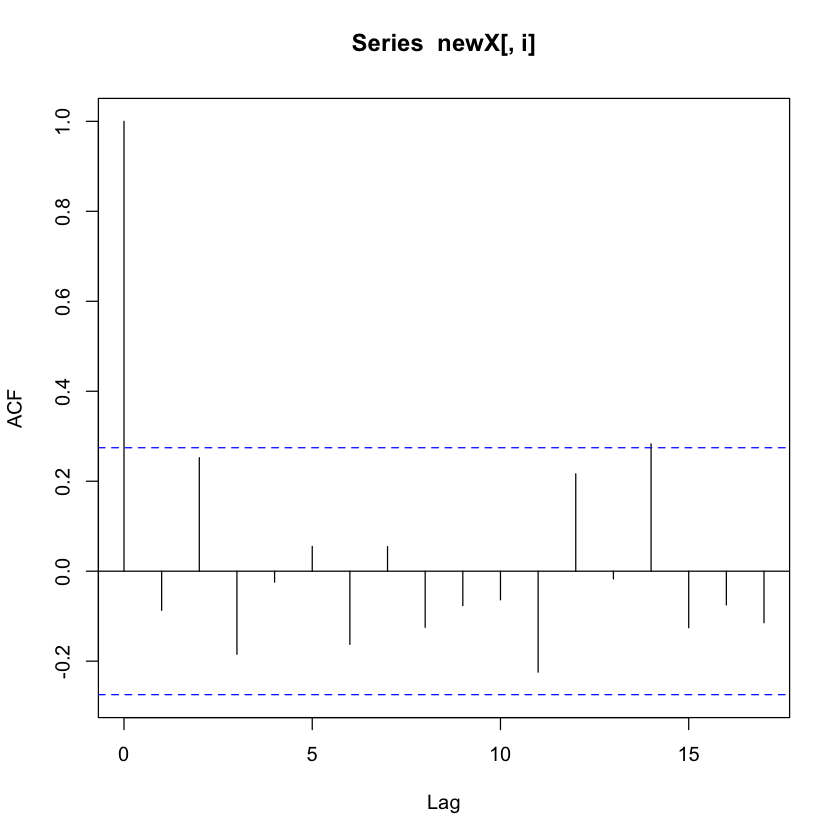

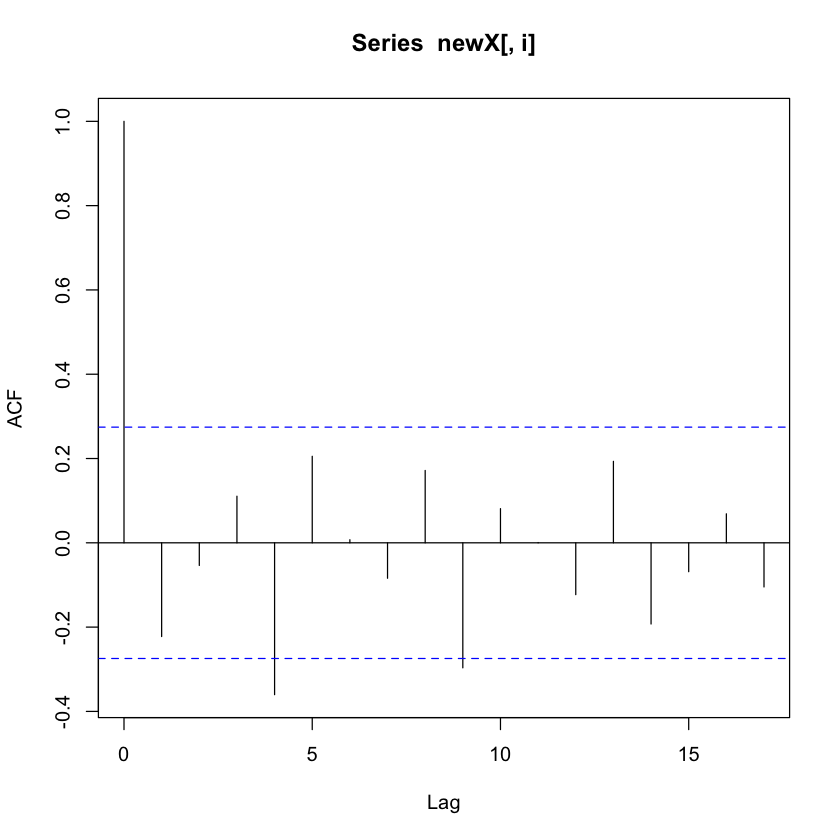

$USDSGD

Autocorrelations of series ‘newX[, i]’, by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000 -0.081  0.040  0.122 -0.130  0.191 -0.088 -0.092 -0.019 -0.196 -0.062 
    11     12     13     14     15     16     17 
-0.114 -0.044 -0.021 -0.054  0.067 -0.145  0.060 

$GDP.Per.Capita.Ratio

Autocorrelations of series ‘newX[, i]’, by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000 -0.264 -0.053  0.257 -0.085 -0.081  0.251 -0.210  0.222 -0.077 -0.086 
    11     12     13     14     15     16     17 
 0.088  0.110 -0.149  0.136 -0.119 -0.201  0.017 

$Interest.Rate.Differential

Autocorrelations of series ‘newX[, i]’, by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000 -0.201 -0.364  0.163  0.183 -0.155 -0.108  0.330 -0.090 -0.264  0.179 
    11     12     13     14     15     16     17 
 0.077 -0.030  0.043 -0.022 -0.043  0.077  0.050 

$CPI.Ratio

Autocorrelat

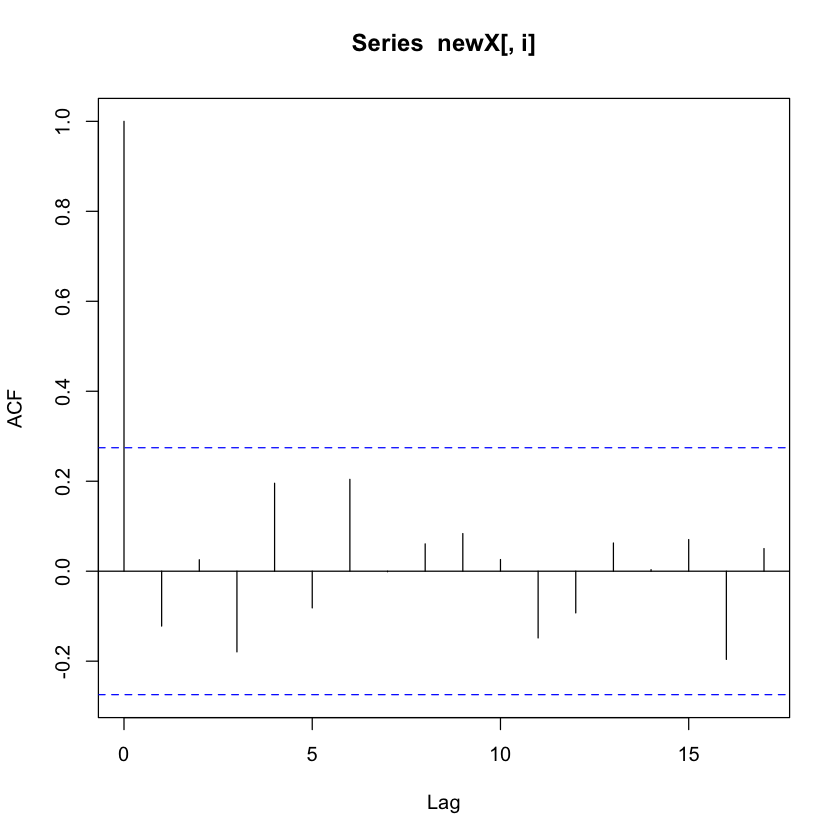

In [12]:
apply(resids,2,acf)

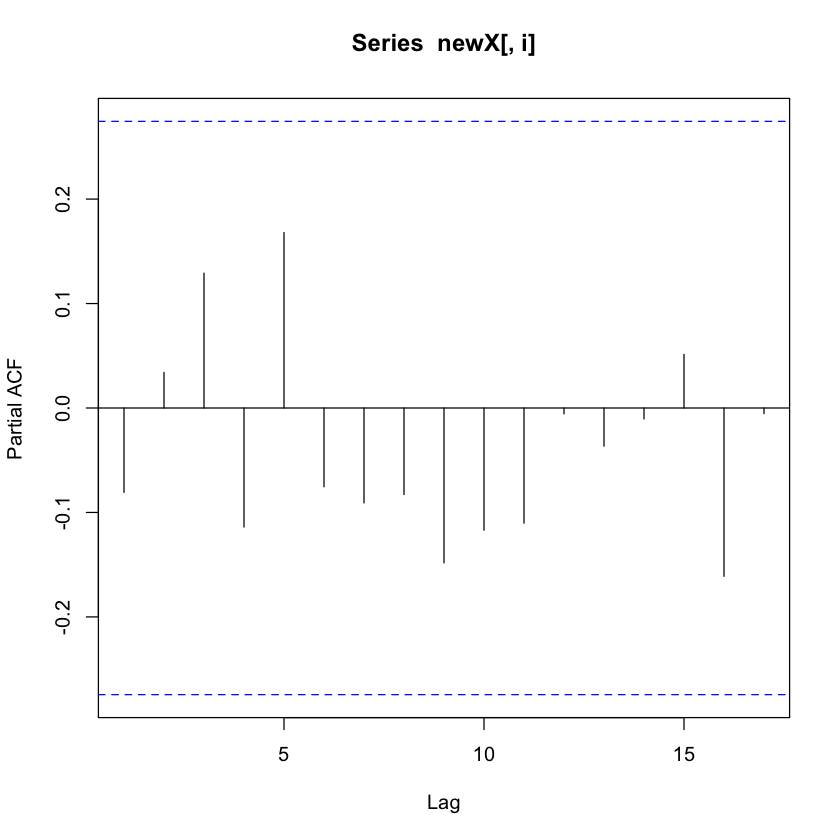

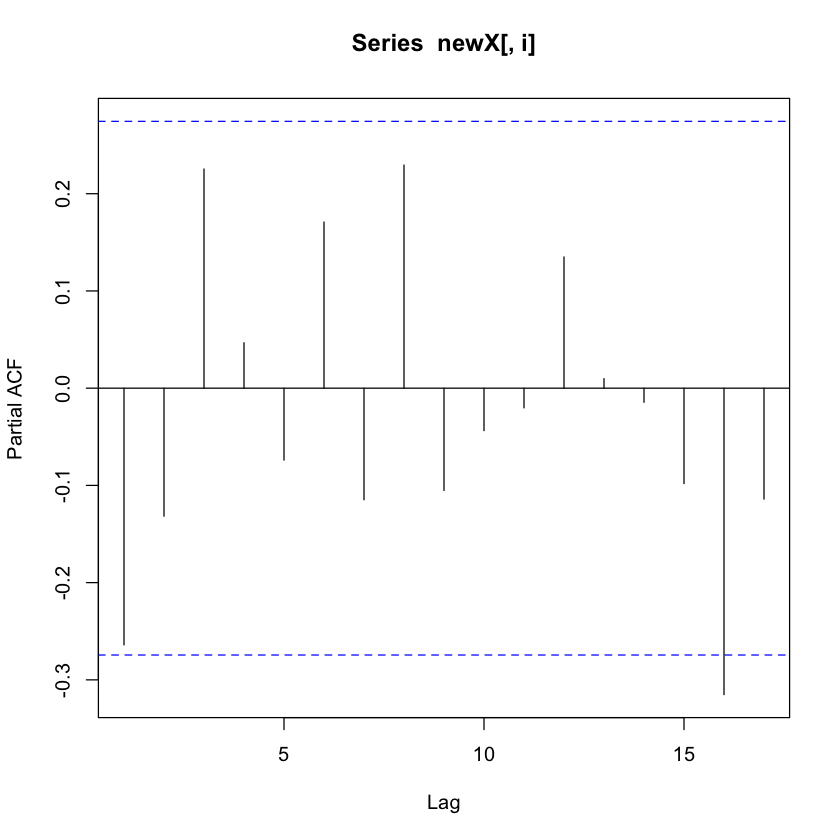

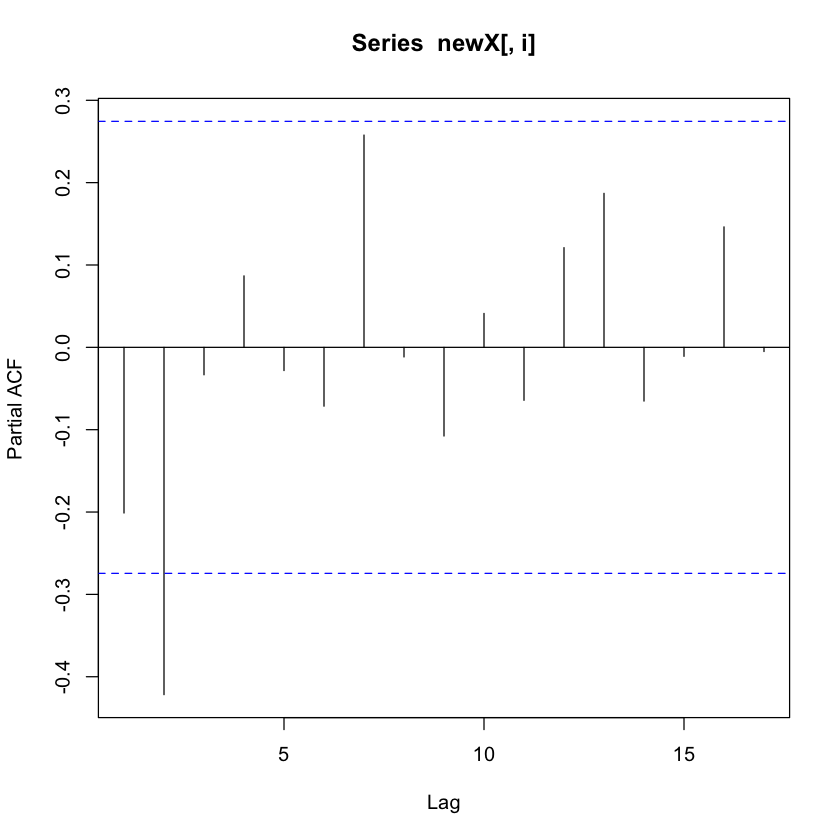

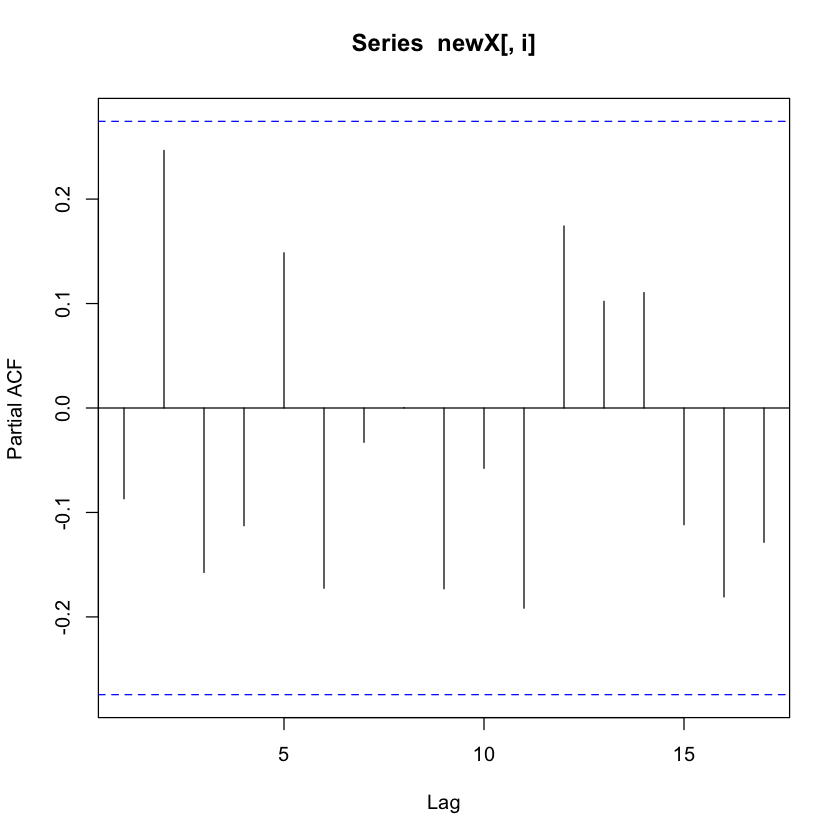

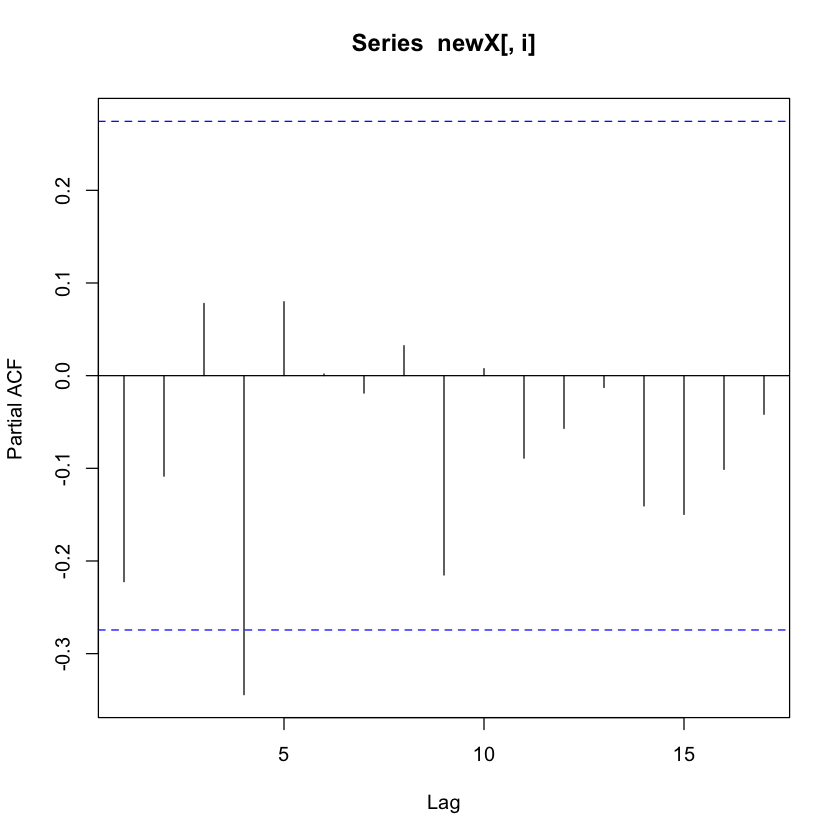

$USDSGD

Partial autocorrelations of series ‘newX[, i]’, by lag

     1      2      3      4      5      6      7      8      9     10     11 
-0.081  0.034  0.129 -0.114  0.168 -0.075 -0.091 -0.083 -0.148 -0.117 -0.110 
    12     13     14     15     16     17 
-0.006 -0.037 -0.010  0.051 -0.161 -0.005 

$GDP.Per.Capita.Ratio

Partial autocorrelations of series ‘newX[, i]’, by lag

     1      2      3      4      5      6      7      8      9     10     11 
-0.264 -0.132  0.225  0.047 -0.074  0.171 -0.115  0.230 -0.105 -0.044 -0.020 
    12     13     14     15     16     17 
 0.135  0.010 -0.015 -0.098 -0.315 -0.114 

$Interest.Rate.Differential

Partial autocorrelations of series ‘newX[, i]’, by lag

     1      2      3      4      5      6      7      8      9     10     11 
-0.201 -0.422 -0.033  0.087 -0.028 -0.071  0.258 -0.012 -0.108  0.041 -0.064 
    12     13     14     15     16     17 
 0.121  0.187 -0.065 -0.011  0.146 -0.005 

$CPI.Ratio

Partial autocorrelations of se

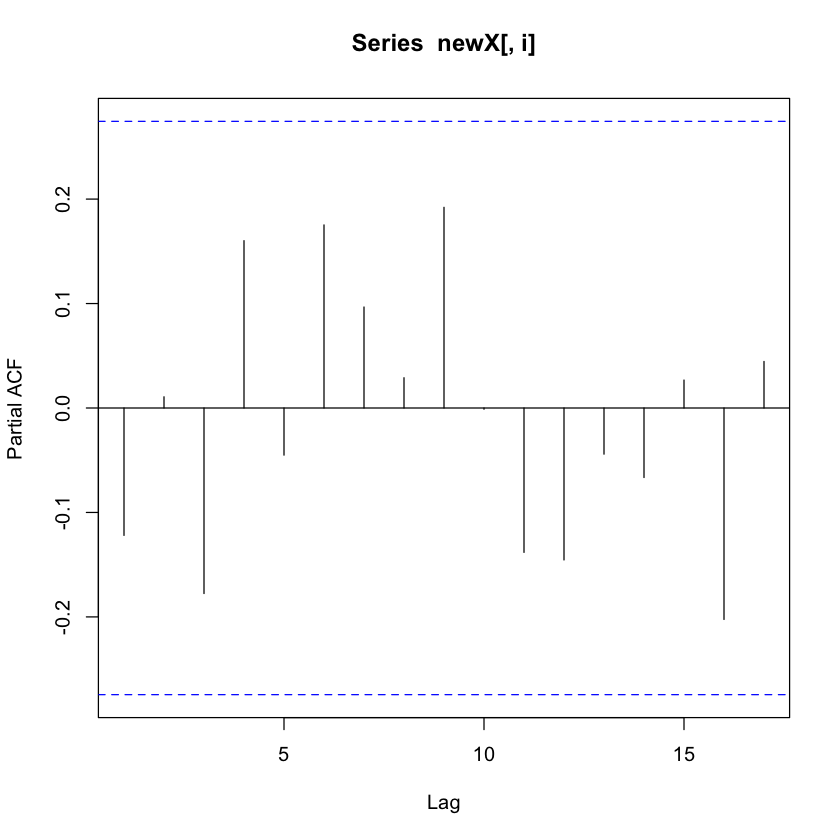

In [13]:
apply(resids,2,pacf)

auto-correlations and partial autocorrelations of the residuals are all comfortably insignificant.    

### Johansen Cointegration tests

In [14]:
trace <- ca.jo(data,ecdet="const",type="trace",K=6)
summary(trace)

eigen <- ca.jo(data,ecdet="const",type="eigen",K=6)
summary(eigen) 


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , without linear trend and constant in cointegration 

Eigenvalues (lambda):
[1]  8.361821e-01  7.478300e-01  6.551767e-01  5.311952e-01  3.680305e-01
[6]  1.822049e-01 -5.551115e-17

Values of teststatistic and critical values of test:

           test 10pct   5pct   1pct
r <= 5 |  10.46  7.52   9.24  12.97
r <= 4 |  34.32 17.85  19.96  24.60
r <= 3 |  73.72 32.00  34.91  41.07
r <= 2 | 129.08 49.65  53.12  60.16
r <= 1 | 200.72 71.86  76.07  84.45
r = 0  | 294.79 97.18 102.14 111.01

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                                      USDSGD.l6 GDP.Per.Capita.Ratio.l6
USDSGD.l6                            1.00000000              1.00000000
GDP.Per.Capita.Ratio.l6             -0.06455735             -0.21396043
Interest.Rate.Differential.l6        0.21823307              0.07360114
CPI.Ratio.l6                       -1


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , without linear trend and constant in cointegration 

Eigenvalues (lambda):
[1]  8.361821e-01  7.478300e-01  6.551767e-01  5.311952e-01  3.680305e-01
[6]  1.822049e-01 -5.551115e-17

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 5 | 10.46  7.52  9.24 12.97
r <= 4 | 23.86 13.75 15.67 20.20
r <= 3 | 39.39 19.77 22.00 26.81
r <= 2 | 55.37 25.56 28.14 33.24
r <= 1 | 71.64 31.66 34.40 39.79
r = 0  | 94.07 37.45 40.30 46.82

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                                      USDSGD.l6 GDP.Per.Capita.Ratio.l6
USDSGD.l6                            1.00000000              1.00000000
GDP.Per.Capita.Ratio.l6             -0.06455735             -0.21396043
Interest.Rate.Differential.l6        0.21823307              0.07360114
CPI.Ratio.l6                    

Both tests strongly reject the hypotheses that there are no or at most 4 cointegration relationship but fail to reject that there are at most 5 cointegration relationships between these variables.     

Thus, we conclude that there are 5 cointegration relations between the variables, on the premise of the existence of cointegration relationships, VEC modeling can be further conducted.

### VECM Estimation and Analysis

In [15]:
# Since the lag order of VAR is 6, VECM’s lag order should be 5.
vecm <- VECM(data,lag=5,r=5,estim="ML")
summary(vecm) 

#############
###Model VECM 
#############
Full sample size: 58 	End sample size: 52
Number of variables: 6 	Number of estimated slope parameters 216
AIC -818.8674 	BIC -387.6425 	SSR 236.1531
Cointegrating vector (estimated by ML):
          USDSGD GDP Per Capita Ratio Interest Rate Differential     CPI Ratio
r1  1.000000e+00        -3.469447e-17              -2.428613e-17 -4.274359e-15
r2  2.220446e-15         1.000000e+00              -1.804112e-16 -8.271162e-15
r3 -2.220446e-16         3.885781e-16               1.000000e+00  3.996803e-15
r4  0.000000e+00        -4.336809e-18              -8.673617e-19  1.000000e+00
r5 -2.220446e-16         4.440892e-16               1.110223e-16  0.000000e+00
   Net Foreign Asset Holding Ratio Current Acc Balance Gap
r1                   -1.387779e-17             0.014346054
r2                   -9.714451e-17             0.080543117
r3                    0.000000e+00            -0.077957263
r4                    0.000000e+00            -0.00988515

So the first cointegration equation is:    
USDSGD = -3.469447e-17 * GDP - 2.428613e-17 * IR - 4.274359e-15 * CPI - 1.387779e-17 * FA + 0.014346054 * CA     

From this equation it can be seen that, other things equal, the most influential factor on USDSGD is the (CA)Current Acc Balance Gap, each percentage-point increase in CA will cause the increase of 0.014346054 percentage points in USDSGD.

In [16]:
eigen.rls <- cajorls(eigen, r = 5)
eigen.rls$rlm


Call:
lm(formula = substitute(form1), data = data.mat)

Coefficients:
                                     USDSGD.d    GDP.Per.Capita.Ratio.d
ect1                                 -7.845e-01  -3.630e-01            
ect2                                  1.720e-01   7.425e-02            
ect3                                 -2.745e-02   2.616e-02            
ect4                                  4.123e+00   3.609e+00            
ect5                                  3.803e-02   6.329e-02            
USDSGD.dl1                            2.184e-01   1.290e+00            
GDP.Per.Capita.Ratio.dl1              2.231e-03  -1.285e-01            
Interest.Rate.Differential.dl1       -2.087e-03   1.185e-03            
CPI.Ratio.dl1                         2.954e+00   1.284e+00            
Net.Foreign.Asset.Holding.Ratio.dl1   1.535e-02   2.892e-02            
Current.Acc.Balance.Gap.dl1          -1.256e-02  -1.353e-02            
USDSGD.dl2                           -3.576e-01  -7.694e-02      

In [17]:
summary(eigen.rls$rlm)

Response USDSGD.d :

Call:
lm(formula = USDSGD.d ~ ect1 + ect2 + ect3 + ect4 + ect5 + USDSGD.dl1 + 
    GDP.Per.Capita.Ratio.dl1 + Interest.Rate.Differential.dl1 + 
    CPI.Ratio.dl1 + Net.Foreign.Asset.Holding.Ratio.dl1 + Current.Acc.Balance.Gap.dl1 + 
    USDSGD.dl2 + GDP.Per.Capita.Ratio.dl2 + Interest.Rate.Differential.dl2 + 
    CPI.Ratio.dl2 + Net.Foreign.Asset.Holding.Ratio.dl2 + Current.Acc.Balance.Gap.dl2 + 
    USDSGD.dl3 + GDP.Per.Capita.Ratio.dl3 + Interest.Rate.Differential.dl3 + 
    CPI.Ratio.dl3 + Net.Foreign.Asset.Holding.Ratio.dl3 + Current.Acc.Balance.Gap.dl3 + 
    USDSGD.dl4 + GDP.Per.Capita.Ratio.dl4 + Interest.Rate.Differential.dl4 + 
    CPI.Ratio.dl4 + Net.Foreign.Asset.Holding.Ratio.dl4 + Current.Acc.Balance.Gap.dl4 + 
    USDSGD.dl5 + GDP.Per.Capita.Ratio.dl5 + Interest.Rate.Differential.dl5 + 
    CPI.Ratio.dl5 + Net.Foreign.Asset.Holding.Ratio.dl5 + Current.Acc.Balance.Gap.dl5 - 
    1, data = data.mat)

Residuals:
      Min        1Q    Median        3Q   

In [18]:
eigen.rls$beta

,ect1,ect2,ect3,ect4,ect5
USDSGD.l6,1.000000e+00,-3.663736e-15,6.106227e-16,-4.683753e-17,1.998401e-15
GDP.Per.Capita.Ratio.l6,-1.752071e-16,1.000000e+00,-2.498002e-16,-4.336809e-18,1.110223e-16
Interest.Rate.Differential.l6,7.979728e-17,-5.689893e-16,1.000000e+00,3.469447e-18,0.000000e+00
CPI.Ratio.l6,-3.275158e-15,4.440892e-16,9.769963e-15,1.000000e+00,-1.776357e-15
Net.Foreign.Asset.Holding.Ratio.l6,-1.387779e-17,6.938894e-17,5.551115e-17,5.204170e-18,1.000000e+00
Current.Acc.Balance.Gap.l6,1.299677e-02,7.566401e-02,-7.724581e-02,-9.974402e-03,-2.683315e-01
constant,-9.206674e-01,1.511119e+00,-1.056667e-01,7.592893e-01,-6.126095e+00


Adjustment parameters are estimated in ect.     
The cointegrating vector is estimated in 𝛽.     
We have included a constant in the cointegrating relationship. 

### Forecast USD/SGD

Once coeffs are estimated, we can calculate FX for past periods starting from regression equation. 

In [19]:
frcastvecm <- predict(vecm,n.ahead=10)
frcastvecm 
summary(frcastvecm)

,USDSGD,GDP Per Capita Ratio,Interest Rate Differential,CPI Ratio,Net Foreign Asset Holding Ratio,Current Acc Balance Gap
59,1.331755,0.72683818,-3.50727703,-0.9755123,-0.8182919,-19.96910
60,1.227483,0.48873842,-3.43855156,-0.9336419,-1.4020219,-17.11398
61,1.251929,0.24919632,-0.70603471,-0.9112177,-1.8348269,-13.93992
62,1.289053,0.13725823,-2.51213942,-0.9117968,-0.4025979,-13.82157
63,1.304635,0.21649413,-4.32995852,-0.9093564,1.0956456,-17.38059
64,1.288432,0.30921036,-3.01418850,-0.8968077,-0.1309286,-17.25739
65,1.213125,0.23541350,-3.66722335,-0.8877884,-0.9522914,-16.67157
66,1.168935,0.06708893,-0.03305614,-0.8856561,-0.8716465,-14.78166
67,1.210903,-0.02863864,-0.46094773,-0.8951816,0.8774590,-12.60730
68,1.237848,0.01470351,-0.80106770,-0.9042395,2.9398347,-13.51211


     USDSGD      GDP Per Capita Ratio Interest Rate Differential
 Min.   :1.169   Min.   :-0.02864     Min.   :-4.32996          
 1st Qu.:1.217   1st Qu.: 0.08463     1st Qu.:-3.49010          
 Median :1.245   Median : 0.22595     Median :-2.76316          
 Mean   :1.252   Mean   : 0.24163     Mean   :-2.24704          
 3rd Qu.:1.289   3rd Qu.: 0.29421     3rd Qu.:-0.72979          
 Max.   :1.332   Max.   : 0.72684     Max.   :-0.03306          
   CPI Ratio       Net Foreign Asset Holding Ratio Current Acc Balance Gap
 Min.   :-0.9755   Min.   :-1.8348                 Min.   :-19.97         
 1st Qu.:-0.9117   1st Qu.:-0.9321                 1st Qu.:-17.22         
 Median :-0.9068   Median :-0.6104                 Median :-15.73         
 Mean   :-0.9111   Mean   :-0.1500                 Mean   :-15.71         
 3rd Qu.:-0.8956   3rd Qu.: 0.6254                 3rd Qu.:-13.85         
 Max.   :-0.8857   Max.   : 2.9398                 Max.   :-12.61         

In [20]:
# plot the predicted values 
Year <- c(2018,2019,2020,2021,2022,2023,2024,2025,2026,2027)
predict_df <- cbind(Year,frcastvecm)
predict_df

,Year,USDSGD,GDP Per Capita Ratio,Interest Rate Differential,CPI Ratio,Net Foreign Asset Holding Ratio,Current Acc Balance Gap
59,2018,1.331755,0.72683818,-3.50727703,-0.9755123,-0.8182919,-19.96910
60,2019,1.227483,0.48873842,-3.43855156,-0.9336419,-1.4020219,-17.11398
61,2020,1.251929,0.24919632,-0.70603471,-0.9112177,-1.8348269,-13.93992
62,2021,1.289053,0.13725823,-2.51213942,-0.9117968,-0.4025979,-13.82157
63,2022,1.304635,0.21649413,-4.32995852,-0.9093564,1.0956456,-17.38059
64,2023,1.288432,0.30921036,-3.01418850,-0.8968077,-0.1309286,-17.25739
65,2024,1.213125,0.23541350,-3.66722335,-0.8877884,-0.9522914,-16.67157
66,2025,1.168935,0.06708893,-0.03305614,-0.8856561,-0.8716465,-14.78166
67,2026,1.210903,-0.02863864,-0.46094773,-0.8951816,0.8774590,-12.60730
68,2027,1.237848,0.01470351,-0.80106770,-0.9042395,2.9398347,-13.51211


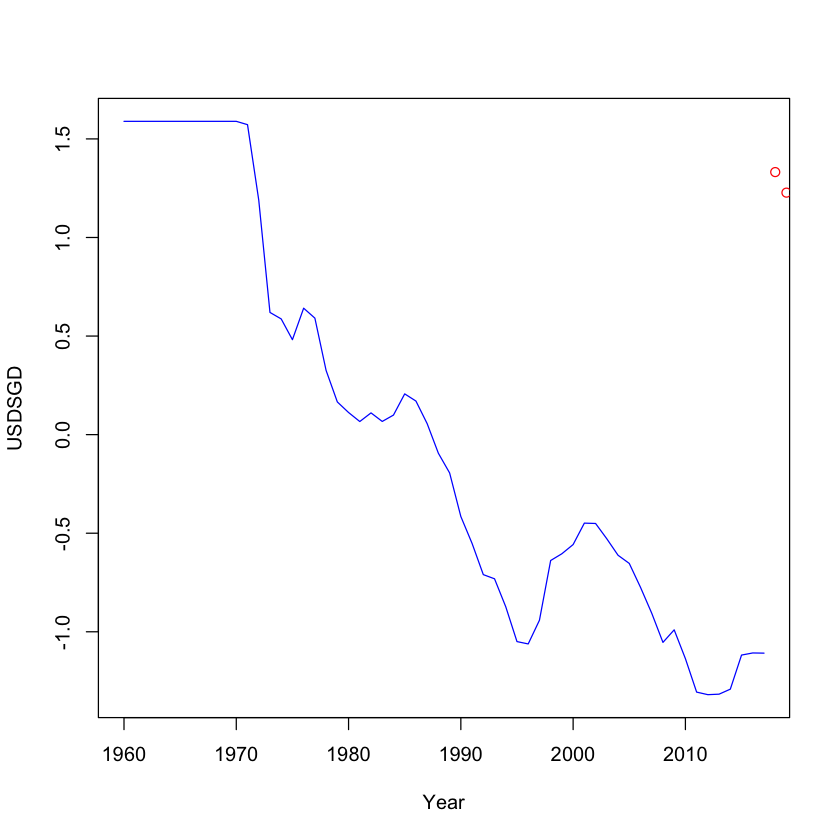

In [21]:
plot(fx,type="l",col="blue")
points(predict_df[,1],predict_df[,2],col="red")

# References

[1] A.Buteikis, “Vilniaus Universitetas”.    
[2] The equilibrium excahnge rate according to PPP and UIP. Dominick Stephens 2004.      
[3] Exchange rates and economic fundations: a methodological comparison of BEERs and FEERs. Peter B. Clark, Ronald Macdonald.       
[4] Concepts to Calculate Equilibrium Exchange Rates: An Overview. Ronald MacDonald.     
[5] VAR, SVAR and SVEC Models: Implementation Within R Package vars.Bernhard Pfaff.Journal of Statistical Software 2008.     
[6] VECM Model Analysis of Carbon Emissions, GDP, and International Crude Oil Prices.Xiaohua Zou.Hindawi 2018.     
[7] Behavioural Equilibrium Exchange Rate (BEER).ROTHKO RESEARCH LTD.